# Part I – Forecasting TTF Natural Gas Prices for Reinforcement Learning-Based Hedging

## Introduction

This notebook represents **Part 1 of a two-stage forecasting-to-hedging pipeline**, aimed at developing a structured and temporally consistent framework for **risk-aware decision-making in natural gas markets**.

The primary objective of this first stage is to **predict day-ahead TTF front-month natural gas prices** using a variety of models:
- **Univariate deep learning architectures** (LSTM, ensembles) trained on historical gas prices,
- **Multivariate models** incorporating exogenous variables (e.g., VIX, storage levels, geopolitical indices),

These forecasts are not an end in themselves. Instead, their purpose is to feed into **Part 2**, where a **reinforcement learning (RL) agent** will use the predicted signals to construct and test **hedging strategies** under different market regimes. The final goal is to evaluate whether models that leverage advanced forecasts can improve hedging effectiveness versus a series of benchmark models and naïve baselines.

### Structure of this Notebook:

1. **Data Preprocessing**: Loading, cleaning, and structuring TTF and exogenous time series.  
2. **Exploratory Analysis**: Visualizations and statistical tests (ACF, Ljung-Box, stationarity) to assess autocorrelation and dynamics.  
3. **Statistical Benchmark**: Rolling ARIMA forecasts for baseline comparison.
4. **Univariate Models**: LSTM, and two ensemble models trained on lagged gas prices.  
5. **Multivariate Models**: Deep learning models extended with exogenous features.  
6. **Evaluation Metrics**: Comparison using MSE and RMSE in original price scale.  
7. **Rolling Regime Classification**: A final transformation of the forecast series into discrete volatility and directional regimes to serve as interpretable inputs for RL training.


# Data loading and preprocessing

In [56]:
# Loading Libraries & Data
import warnings
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt


import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

# Fix seeds for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load the TTF dataset
data = pd.read_csv("/Users/gio/Desktop/TRINITY COLLEGE/DISSERTATION/New proposal/data/Reinforcement_Learning/TTF_FrontMonth_forward_filled.csv")
print("Dataset Info:")
print(data.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4017 entries, 0 to 4016
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4017 non-null   object 
 1   Price   4017 non-null   float64
dtypes: float64(1), object(1)
memory usage: 62.9+ KB
None


### Dataset Characteristics:
- **Size**: 4,017 daily observations
- **Variables**: Date and Price (EUR/MWh)
- **Coverage**: From 2014 to 2024. Captures multiple market cycles and the 2021-2022 energy crisis

The preprocessing transforms raw data into proper time series format. Setting date as index enables pandas' time series functionality.


First 3 rows:
        Date   Price
0 2014-01-02  27.302
1 2014-01-03  27.213
2 2014-01-04  27.213

Last 3 rows:
           Date   Price
4014 2024-12-29  47.731
4015 2024-12-30  47.633
4016 2024-12-31  48.889

Data after processing:
            gas_price
date                 
2024-12-29     47.731
2024-12-30     47.633
2024-12-31     48.889

Data range: 2014-01-02 00:00:00 to 2024-12-31 00:00:00
Total records: 4017

=== EXPLORATORY DATA ANALYSIS ===
Missing values check:
gas_price    0
dtype: int64


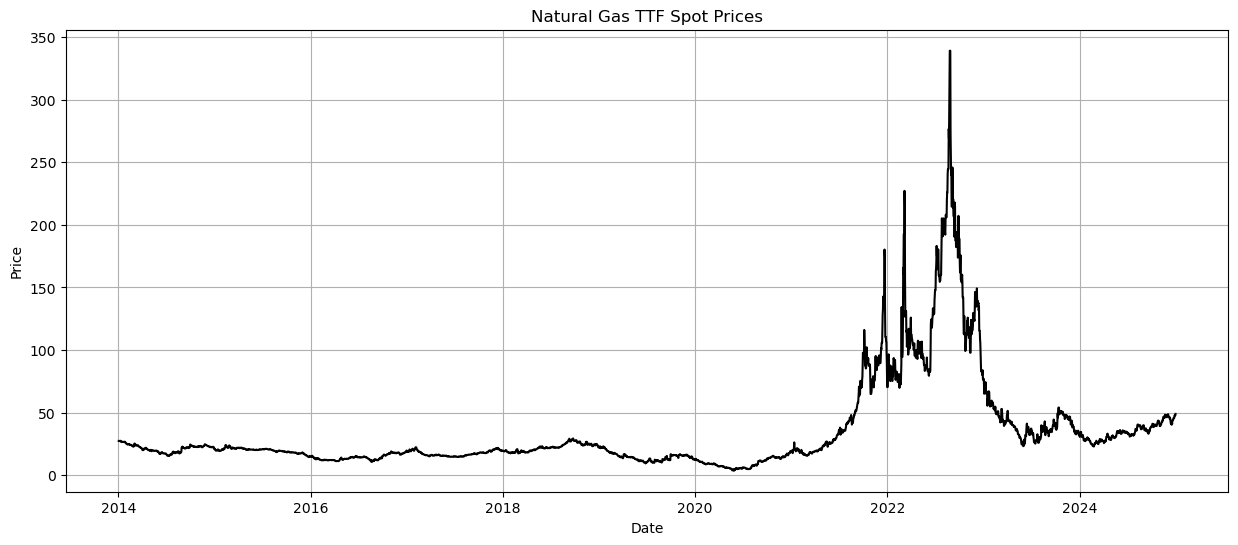

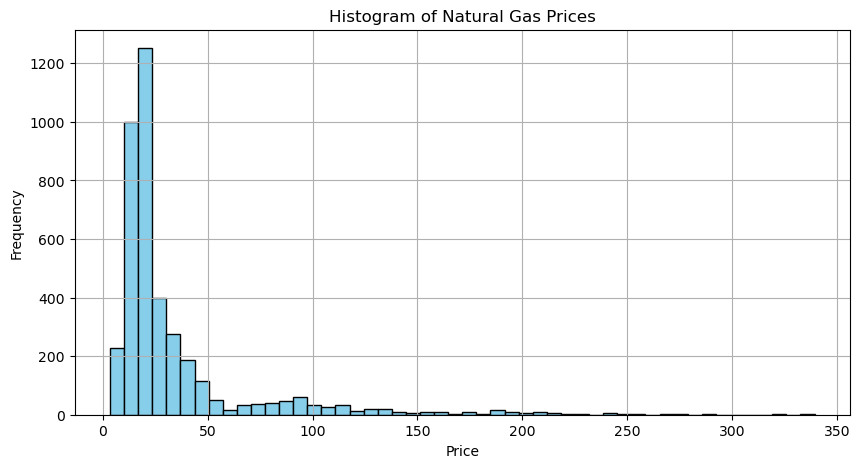

In [58]:
# Data Preparation
# Convert Date column with correct format (YYYY-MM-DD)
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")
print("\nFirst 3 rows:")
print(data.head(3))

print("\nLast 3 rows:")
print(data.tail(3))

# Renaming columns
data = data.rename({'Date': 'date', 'Price': 'gas_price'}, axis=1)

# Setting Date as index
data = data.set_index('date')

# Sort data by date
data = data.sort_index()

print("\nData after processing:")
print(data.tail(3))

print(f"\nData range: {data.index[0]} to {data.index[-1]}")
print(f"Total records: {len(data)}")

# Exploratory Data Analysis
print("\n=== EXPLORATORY DATA ANALYSIS ===")

# Missing Values
print("Missing values check:")
print(data.isnull().sum())

# Fill missing values if any
if data.isnull().sum().sum() > 0:
    data = data.fillna(method='pad')
    print("Missing values after forward fill:")
    print(data.isnull().sum())

# Line Chart
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['gas_price'], color='black')
plt.title('Natural Gas TTF Spot Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Histogram
plt.figure(figsize=(10, 5))
plt.hist(data['gas_price'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Natural Gas Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Key Visual Insights:
- **Pre-2021**: Stable prices below 50 EUR/MWh with seasonal patterns
- **2021-2022**: Extreme volatility with spikes above 300 EUR/MWh (energy crisis)
- **Post-2022**: Elevated but stabilizing prices
- **Distribution**: Right-skewed with long tail, indicating regime-switching behavior

# Stationarity Test for ARIMA

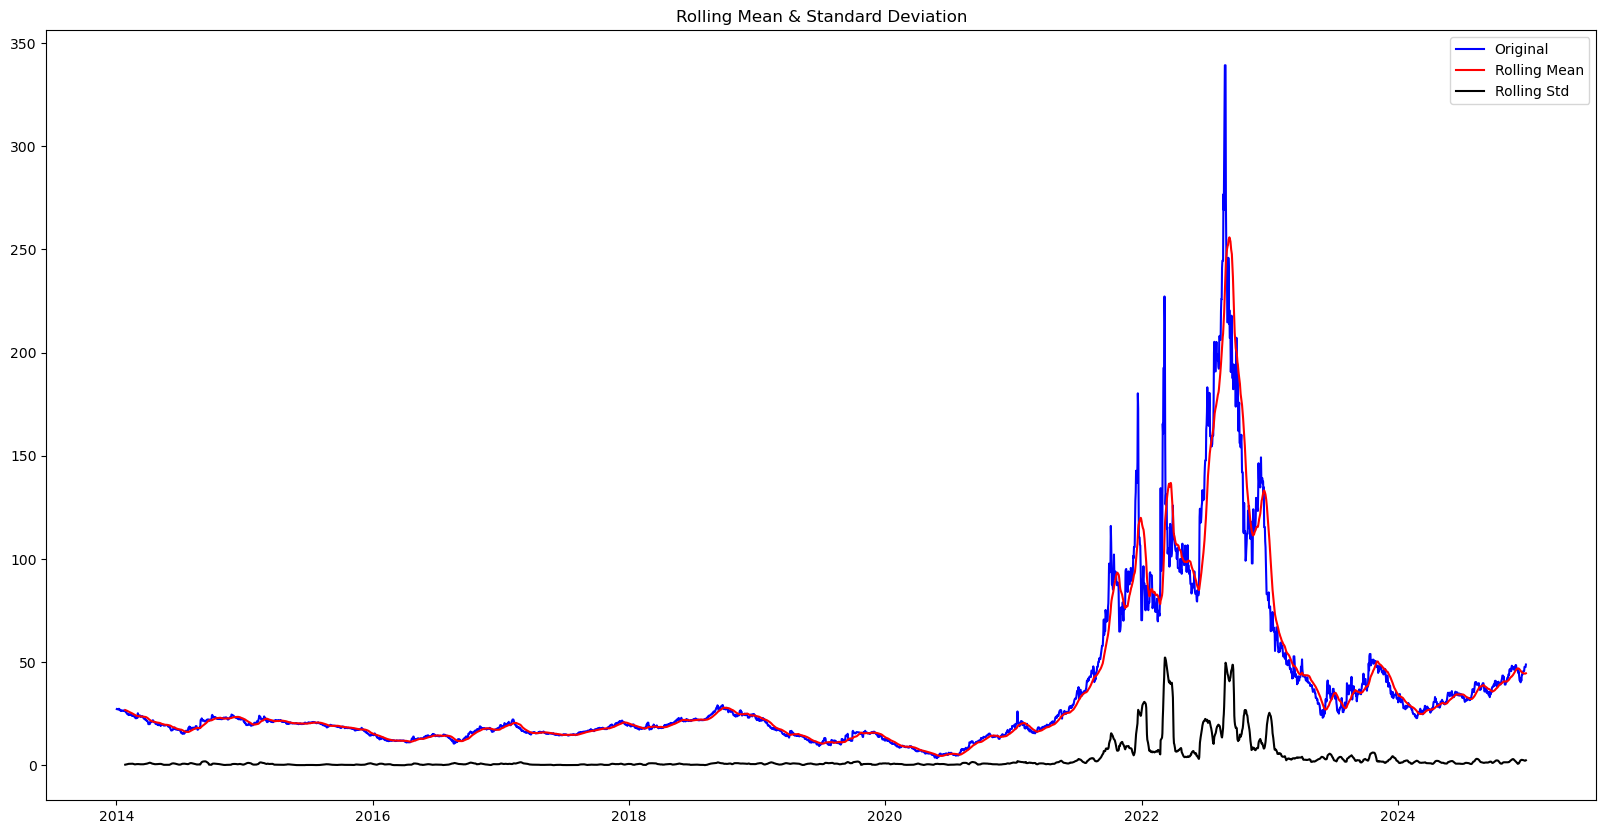

Results of Dickey-Fuller Test:
Test Statistic                   -2.559691
p-value                           0.101618
#Lags Used                       31.000000
Number of Observations Used    3985.000000
Critical Value (1%)              -3.431992
Critical Value (5%)              -2.862266
Critical Value (10%)             -2.567156
dtype: float64

=== TREND ANALYSIS ===


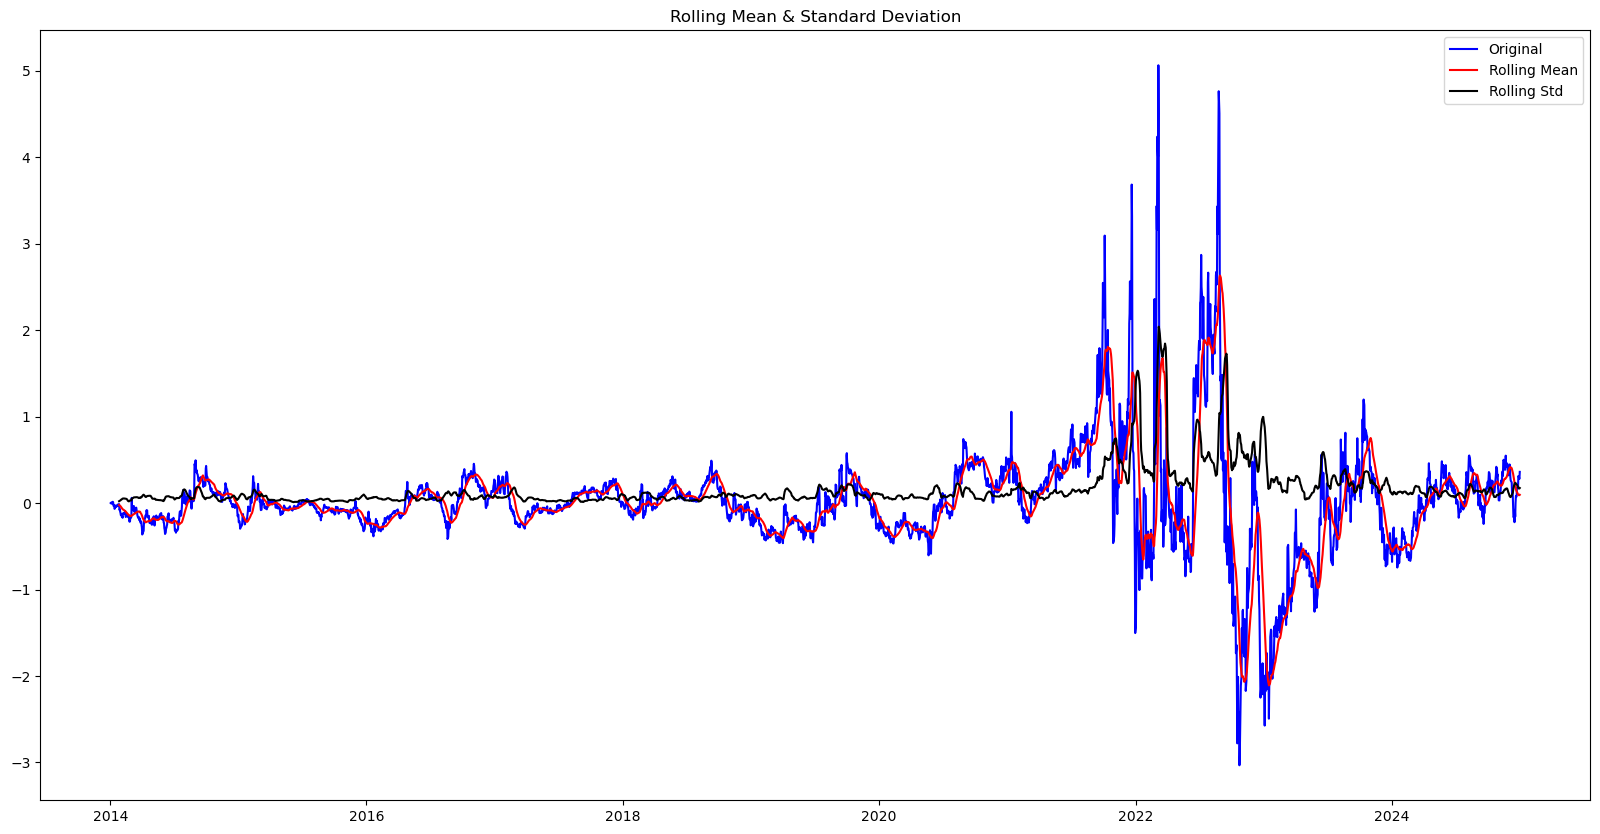

Results of Dickey-Fuller Test:
Test Statistic                -6.474072e+00
p-value                        1.344703e-08
#Lags Used                     2.100000e+01
Number of Observations Used    3.995000e+03
Critical Value (1%)           -3.431988e+00
Critical Value (5%)           -2.862264e+00
Critical Value (10%)          -2.567155e+00
dtype: float64


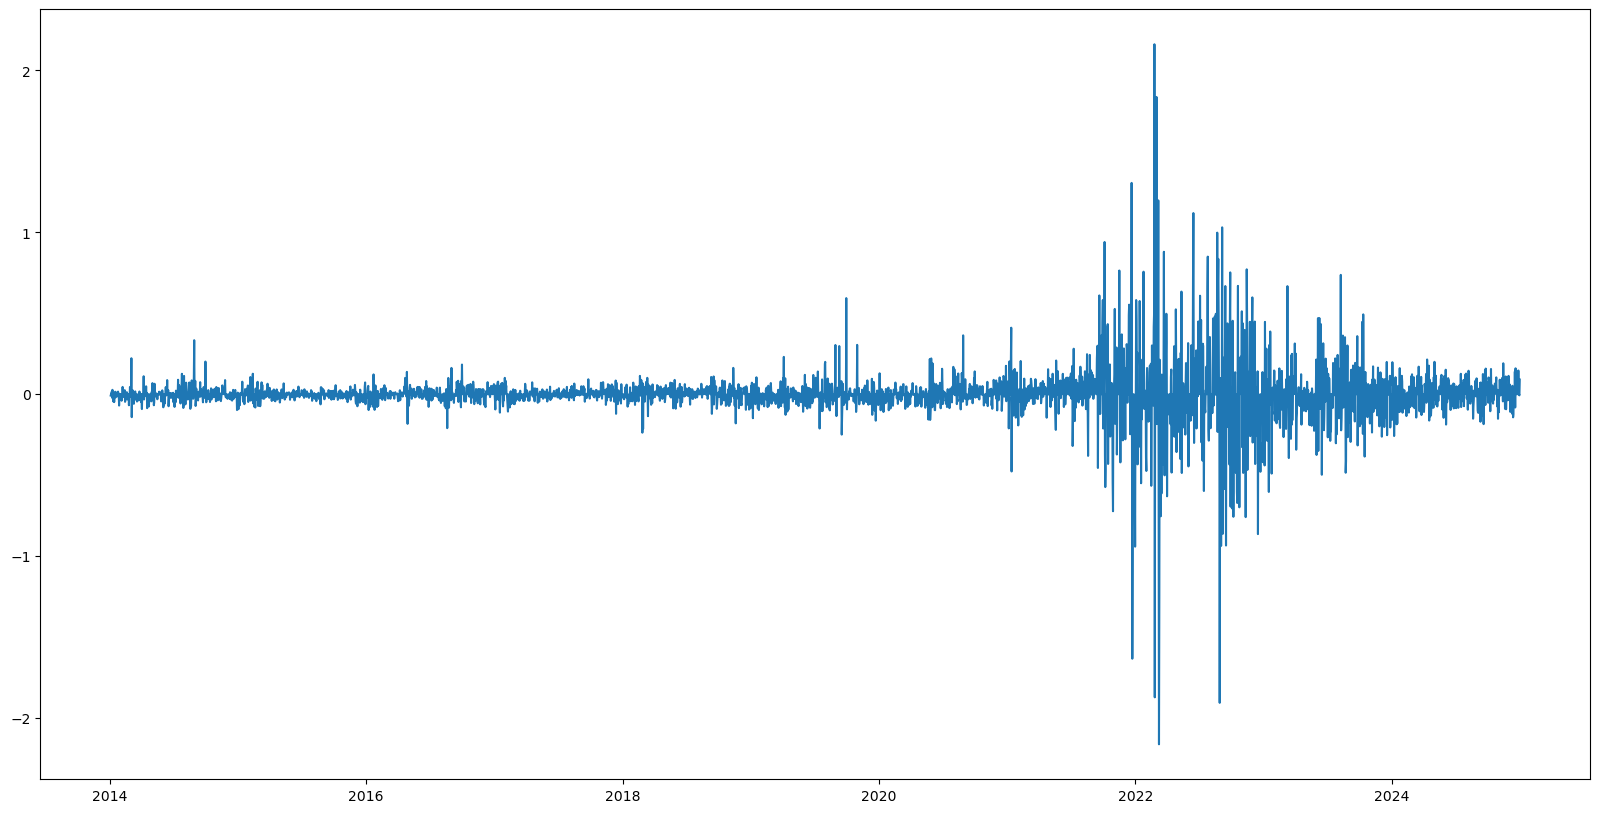

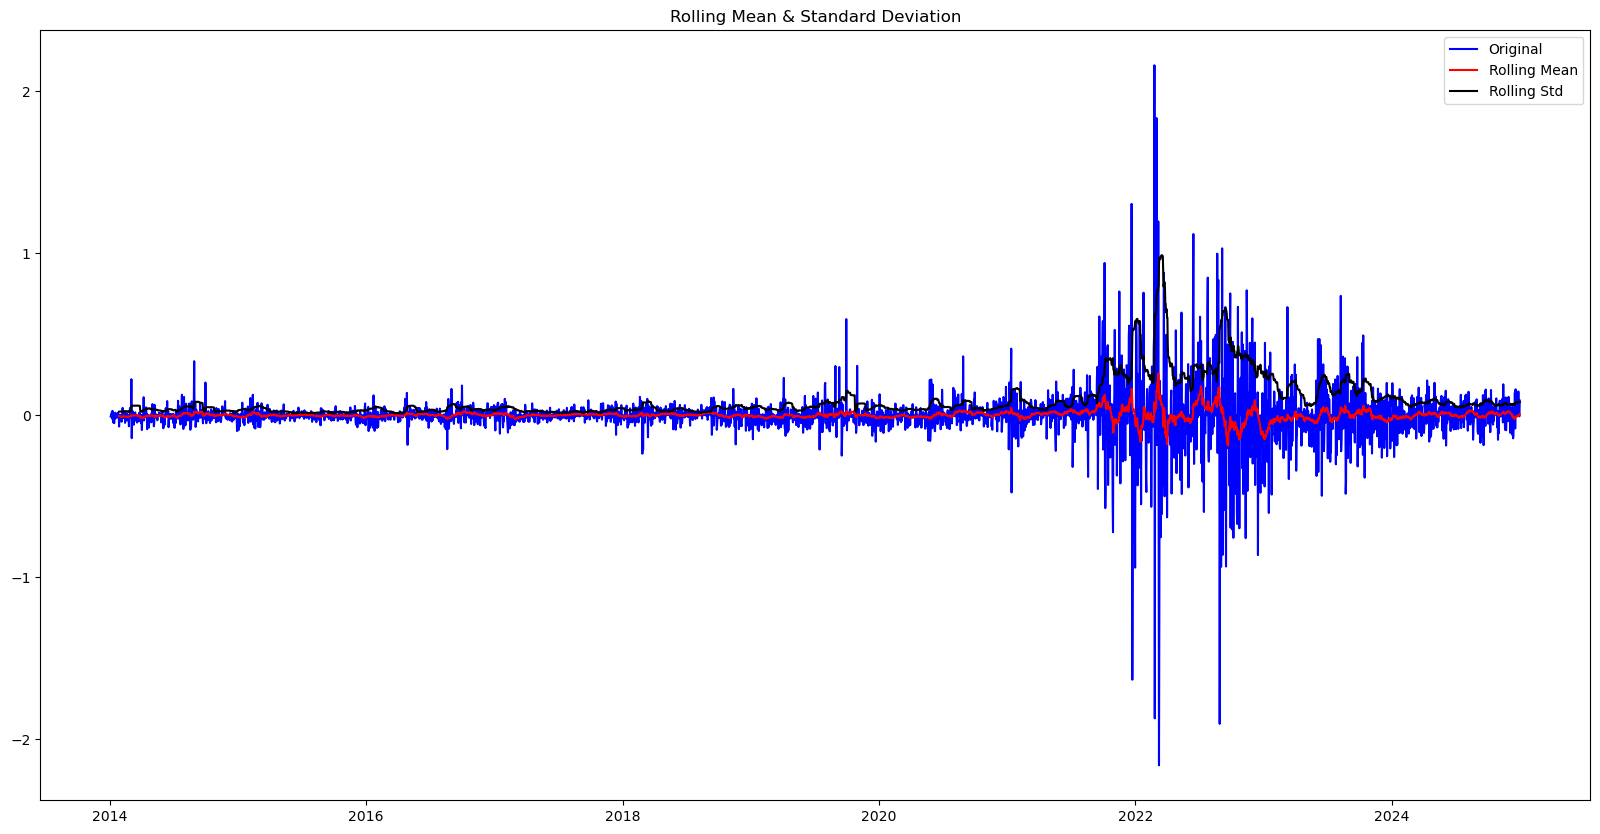

Results of Dickey-Fuller Test:
Test Statistic                -1.231727e+01
p-value                        6.876490e-23
#Lags Used                     3.100000e+01
Number of Observations Used    3.984000e+03
Critical Value (1%)           -3.431992e+00
Critical Value (5%)           -2.862266e+00
Critical Value (10%)          -2.567156e+00
dtype: float64


In [60]:
# Check if Time Series is Stationary
def test_stationarity(timeseries):
    # Determining rolling statistics
    rolmean = timeseries.rolling(25).mean()
    rolstd = timeseries.rolling(25).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(20,10))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

test_stationarity(data['gas_price'])

# Estimating and Eliminating Trends
print("\n=== TREND ANALYSIS ===")

# Exponential Weighted Moving Average
ts_sqrt = np.sqrt(data)
expwighted_avg = ts_sqrt.ewm(halflife=25).mean()
ts_sqrt_ewma_diff = ts_sqrt - expwighted_avg
test_stationarity(ts_sqrt_ewma_diff.dropna())

# Differencing
ts_sqrt_diff = ts_sqrt - ts_sqrt.shift()
plt.figure(figsize=(20,10))
plt.plot(ts_sqrt_diff)
plt.show()

ts_sqrt_diff.dropna(inplace=True)
test_stationarity(ts_sqrt_diff)

### Augmented Dickey-Fuller Test Framework:
- **Null Hypothesis (H₀)**: Series has a unit root (non-stationary)
- **Alternative Hypothesis (H₁)**: Series is stationary
- **Decision Rule**: Reject H₀ if p-value < 0.05 or test statistic < critical values
- **AIC Lag Selection**: Automatically determines optimal lag structure

### Test Results:
- **Original Series**: 
 - Test statistic = -2.56 (> critical value -2.86 at 5% level)
 - p-value = 0.10 (> 0.05)
 - **Decision**: Fail to reject H₀ → Series is non-stationary
- **After Transformations**: 
 - Test statistic = -12.32 (<< critical value -2.86)
 - p-value ≈ 0 (< 0.05)
 - **Decision**: Reject H₀ → Series is stationary

### Transformation Sequence:
1. **Square Root**: Variance stabilization for heteroskedastic data
2. **EWMA Detrending**: Remove local trends (25-day half-life)
3. **First Differencing**: Eliminate unit root behavior

The original series fails the stationarity test because the test statistic (-2.56) is not sufficiently negative compared to the 5% critical value (-2.86), and the p-value (0.10) exceeds the conventional 0.05 threshold. This indicates the presence of unit root behavior typical in financial time series. After systematic transformations, the p-value approaches zero, providing evidence to reject the null hypothesis. This confirms successful achievement of stationarity required for reliable ARIMA modeling.


=== DATA MODELING ===
Length of Train Data: 3651
Length of Test Data: 366

Train data range:
            gas_price
date                 
2014-01-02     27.302
2014-01-03     27.213
            gas_price
date                 
2023-12-30      32.35
2023-12-31      32.35

Test data range:
            gas_price
date                 
2024-01-01     32.350
2024-01-02     30.572
            gas_price
date                 
2024-12-30     47.633
2024-12-31     48.889


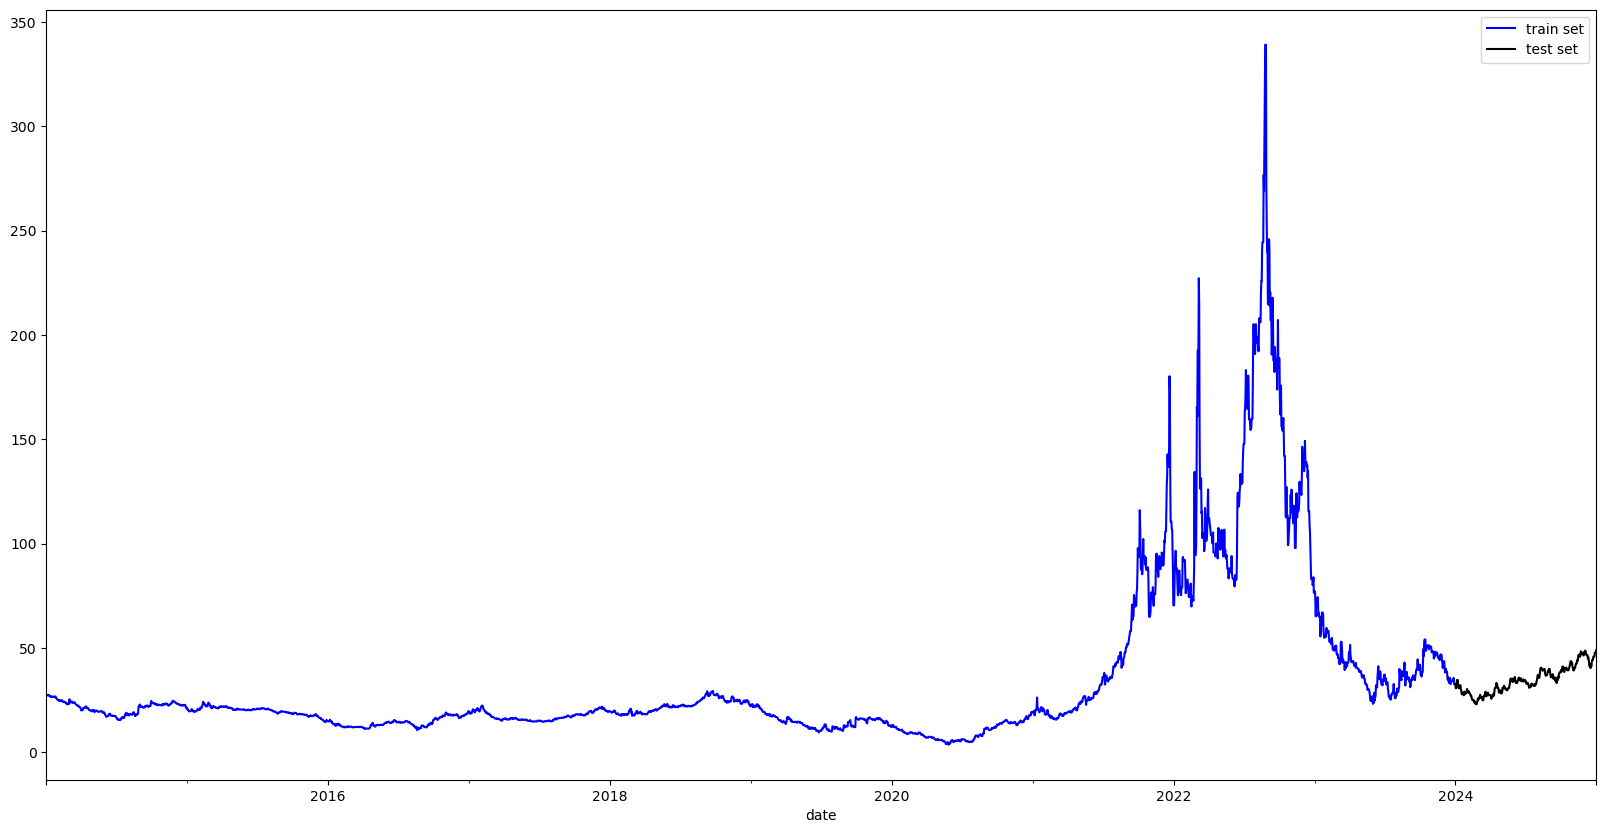

In [62]:
# Data Modeling
print("\n=== DATA MODELING ===")

# Train Test Split
data = data.sort_index()
train = data[data.index <= '2023-12-31']
test = data[data.index >= '2024-01-01']

print(f"Length of Train Data: {len(train)}")
print(f"Length of Test Data: {len(test)}")

print("\nTrain data range:")
print(train.head(2))
print(train.tail(2))

print("\nTest data range:")
print(test.head(2))
print(test.tail(2))

# Plot train/test split
ax = train.plot(figsize=(20, 10), color='b')
test.plot(ax=ax, color='black')
plt.legend(['train set', 'test set'])
plt.show()

### Configuration:
- **Training**: 2014-2023 (3,651 obs, 91%)
- **Testing**: 2024 (366 obs, 9%)

In [67]:
print("\n=== AUTOCORRELATION FUNCTION ===")

# Autocorrelation Function
acf_vals = acf(data['gas_price'], nlags=15)

# Lags from 1 to 15
for lag in range(1, 16):
    print(f"Autocorrelation at lag {lag}: {acf_vals[lag]:.4f}")

print("\n=== LJUNG-BOX TEST FOR AUTOCORRELATION ===")

print("\n=== LJUNG-BOX TEST FOR AUTOCORRELATION (Multiple Lags) ===")

# lagse
lags_to_test = [5, 10, 15]

# test
ljung_results = acorr_ljungbox(data['gas_price'], lags=lags_to_test, return_df=True)

for lag in lags_to_test:
    stat = ljung_results.loc[lag, 'lb_stat']
    pval = ljung_results.loc[lag, 'lb_pvalue']
    print(f"Lag {lag}:  Ljung-Box Stat = {stat:.2f},  p-value = {pval:.4f}")


=== AUTOCORRELATION FUNCTION ===
Autocorrelation at lag 1: 0.9959
Autocorrelation at lag 2: 0.9908
Autocorrelation at lag 3: 0.9863
Autocorrelation at lag 4: 0.9819
Autocorrelation at lag 5: 0.9776
Autocorrelation at lag 6: 0.9734
Autocorrelation at lag 7: 0.9687
Autocorrelation at lag 8: 0.9646
Autocorrelation at lag 9: 0.9604
Autocorrelation at lag 10: 0.9565
Autocorrelation at lag 11: 0.9528
Autocorrelation at lag 12: 0.9490
Autocorrelation at lag 13: 0.9452
Autocorrelation at lag 14: 0.9421
Autocorrelation at lag 15: 0.9390

=== LJUNG-BOX TEST FOR AUTOCORRELATION ===

=== LJUNG-BOX TEST FOR AUTOCORRELATION (Multiple Lags) ===
Lag 5:  Ljung-Box Stat = 19571.39,  p-value = 0.0000
Lag 10:  Ljung-Box Stat = 38311.36,  p-value = 0.0000
Lag 15:  Ljung-Box Stat = 56338.69,  p-value = 0.0000


### Key Statistics:
- **Lag 1**: 0.9959 (extremely high persistence)
- **Lag 15**: 0.9390 (sustained temporal dependence)
- **Ljung-Box Test**: All p-values ≈ 0 (strong serial correlation)

The extraordinarily high autocorrelation (lag-1 = 0.9959) creates conditions highly favorable to autoregressive models. This persistence suggests sophisticated non-linear models may provide only marginal improvements over approaches directly modeling this structure.
However, non-linear and multivariate models may still uncover meaningful relationships with exogenous variables and capture signals that linear autoregressive models inherently miss.

# ARIMA


=== ARIMA BENCHMARK ===

--- ARIMA Rolling Forecast on Train Set ---
Train R² (rolling): 0.9916
Train MSE: 13.4336
Train RMSE: 3.6652

--- ARIMA Rolling Forecast on Test Set ---
Test R² (rolling): 0.9811
Test MSE: 0.7917
Test RMSE: 0.8898


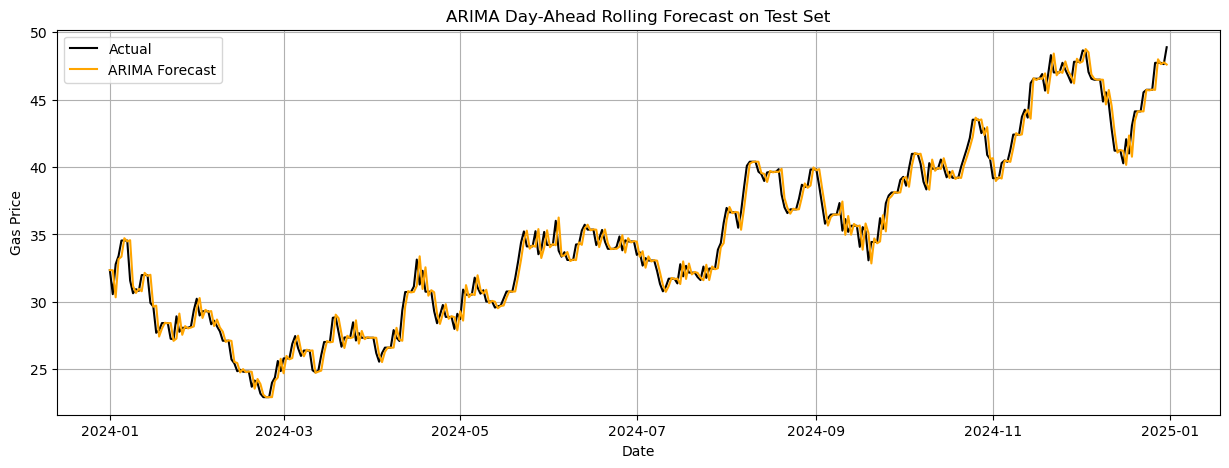

In [69]:
print("\n=== ARIMA BENCHMARK ===")

slot_arima = 30

# === Rolling Forecast on TRAIN ===
print("\n--- ARIMA Rolling Forecast on Train Set ---")
rolling_train_preds = []
history_train = list(train['gas_price'][:slot_arima])
train_dates = train.index[slot_arima:]

for date in train_dates:
    model = ARIMA(history_train, order=(1, 1, 1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)[0]
    rolling_train_preds.append(forecast)
    history_train.append(train.loc[date, 'gas_price'])

# Evaluation (Train)
y_train_true = train['gas_price'][slot_arima:]
r2_arima_train = r2_score(y_train_true, rolling_train_preds)
mse_arima_train = mean_squared_error(y_train_true, rolling_train_preds)
rmse_arima_train = sqrt(mse_arima_train)

print(f"Train R² (rolling): {r2_arima_train:.4f}")
print(f"Train MSE: {mse_arima_train:.4f}")
print(f"Train RMSE: {rmse_arima_train:.4f}")

# === Rolling Forecast on TEST ===
print("\n--- ARIMA Rolling Forecast on Test Set ---")
rolling_test_preds = []
history_test = list(train['gas_price'])

for date in test.index:
    model = ARIMA(history_test, order=(1, 1, 1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)[0]
    rolling_test_preds.append(forecast)
    history_test.append(test.loc[date, 'gas_price'])

# Evaluation (Test)
r2_arima_test = r2_score(test['gas_price'], rolling_test_preds)
mse_arima_test = mean_squared_error(test['gas_price'], rolling_test_preds)
rmse_arima_test = sqrt(mse_arima_test)

print(f"Test R² (rolling): {r2_arima_test:.4f}")
print(f"Test MSE: {mse_arima_test:.4f}")
print(f"Test RMSE: {rmse_arima_test:.4f}")

# Plot - Test
plt.figure(figsize=(15, 5))
plt.plot(test.index, test['gas_price'], label='Actual', color='black')
plt.plot(test.index, rolling_test_preds, label='ARIMA Forecast', color='orange')
plt.title("ARIMA Day-Ahead Rolling Forecast on Test Set")
plt.xlabel("Date")
plt.ylabel("Gas Price")
plt.legend()
plt.grid(True)
plt.show()

- **Method**: Rolling window with daily re-estimation
- **Window**: Expanding from 30-day initial period (matching LSTM and ensembles models window)

### Performance Results:
- **Train R²**: 0.9916
- **Test R²**: 0.9811 
- **Test RMSE**: 0.8898


The rolling ARIMA implementation adapts to changing market conditions through daily re-estimation. The performance metrics show very high forecasting reliability for day ahead forecasting. 


# LSTM


=== LSTM MODEL ===
Original data range: 3.51 to 339.20
Scaled data range: 0.00 to 1.00
Training data shape: (3073, 30, 1), (3073,)
Scaled y_train range: 0.000 to 0.666


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_104 (LSTM)                 │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_176 (Dropout)           │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_105 (LSTM)                 │ (None, 30, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_177 (Dropout)           │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_106 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_178 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 6.1573e-04 - val_loss: 0.0271 - learning_rate: 0.0010
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0033 - val_loss: 0.0300 - learning_rate: 0.0010
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0070 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0068 - val_loss: 0.0189 - learning_rate: 0.0010
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0028 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.7920e-04 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.3810e-04 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5510e-04 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 9/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7410e-04 - val_loss: 0.0027 - learning_rat

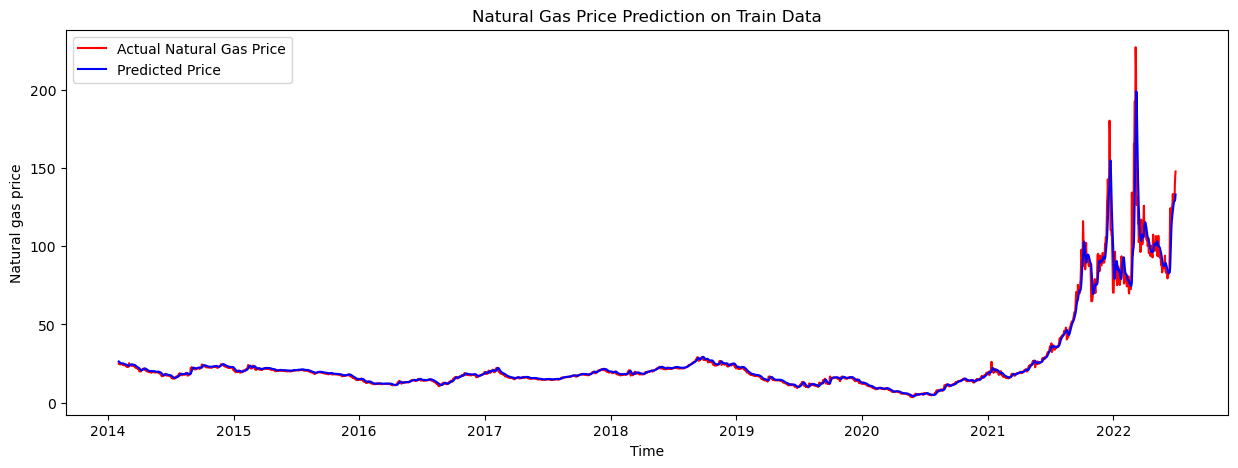

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Test comparison:
            gas_price    gp_pred
date                            
2024-01-01     32.350  34.041981
2024-01-02     30.572  33.692932
2024-01-03     32.795  33.249817
            gas_price    gp_pred
date                            
2024-12-29     47.731  46.863129
2024-12-30     47.633  47.364265
2024-12-31     48.889  47.767494


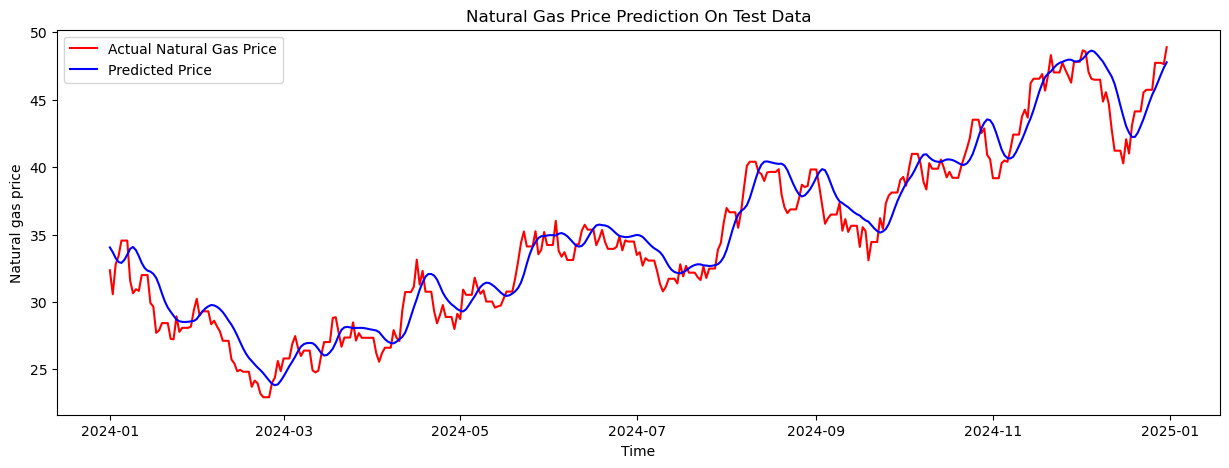

LSTM Results:
Train Data:
MSE: 21.502069, RMSE: 4.6370, R²: 0.9662
Test Data:
MSE: 2.395827, RMSE: 1.5478, R²: 0.9429


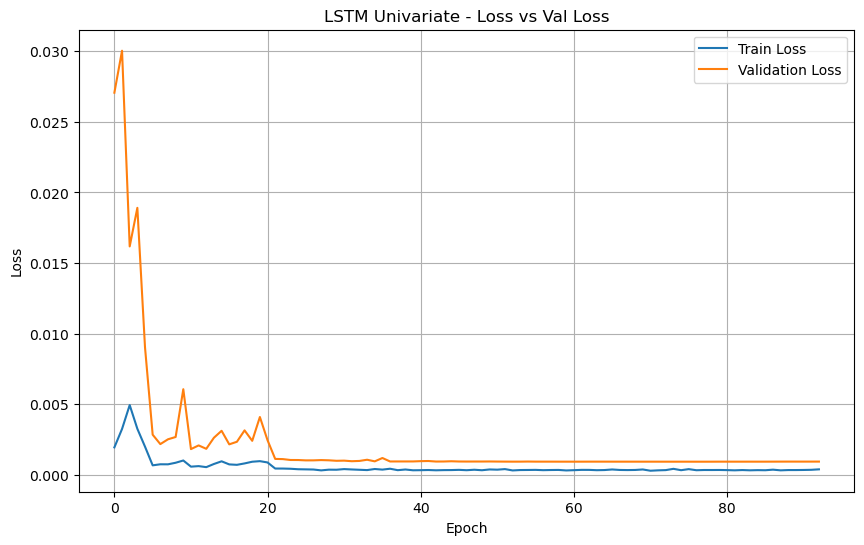

In [71]:
# LSTM Model
print("\n=== LSTM MODEL ===")

# Data Normalization for LSTM
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit scaler on training data and transform both train and test
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

print(f"Original data range: {train.min().values[0]:.2f} to {train.max().values[0]:.2f}")
print(f"Scaled data range: {train_scaled.min():.2f} to {train_scaled.max():.2f}")

# Prepare data for LSTM
slot = 30
val_split_idx = int(len(train_scaled) * 0.85)
train_univ_scaled = train_scaled[:val_split_idx]
val_univ_scaled = train_scaled[val_split_idx - slot:]

x_train_univ, y_train_univ = [], []
for i in range(slot, len(train_univ_scaled)):
    x_train_univ.append(train_univ_scaled[i-slot:i, 0])
    y_train_univ.append(train_univ_scaled[i, 0])

x_train_univ = np.array(x_train_univ)
y_train_univ = np.array(y_train_univ)
x_train_univ = x_train_univ.reshape((x_train_univ.shape[0], slot, 1))

x_train = x_train_univ
y_train = y_train_univ

# Validation
x_val_univ, y_val_univ = [], []
for i in range(slot, len(val_univ_scaled)):
    x_val_univ.append(val_univ_scaled[i-slot:i, 0])
    y_val_univ.append(val_univ_scaled[i, 0])

x_val_univ = np.array(x_val_univ)
y_val_univ = np.array(y_val_univ)
x_val_univ = x_val_univ.reshape((x_val_univ.shape[0], slot, 1))

# index for a=validation
val_dates = train.index[val_split_idx:]
val_index = val_dates[slot:]

print(f"Training data shape: {x_train_univ.shape}, {y_train_univ.shape}")
print(f"Scaled y_train range: {y_train_univ.min():.3f} to {y_train_univ.max():.3f}")

# Build LSTM model
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units=50, input_shape=(slot, 1), return_sequences=True))
lstm_model.add(tf.keras.layers.Dropout(0.3))  # Add dropout to prevent overfitting
lstm_model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
lstm_model.add(tf.keras.layers.Dropout(0.3))
lstm_model.add(tf.keras.layers.LSTM(units=50, return_sequences=False))
lstm_model.add(tf.keras.layers.Dropout(0.3))
lstm_model.add(tf.keras.layers.Dense(units=1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.summary()

# Train LSTM model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

history = lstm_model.fit(
    x_train_univ, y_train_univ,
    validation_data=(x_val_univ, y_val_univ),
    epochs=100, batch_size=32, verbose=1, shuffle=False,
    callbacks=[early_stopping, reduce_lr]
)

# Model Evaluation - Train Data
print("\n=== MODEL EVALUATION ===")
yp_train_lstm = lstm_model.predict(x_train_univ)

# INVERSE TRANSFORM to original scale
yp_train_lstm_rescaled = scaler.inverse_transform(yp_train_lstm)
y_train_rescaled = scaler.inverse_transform(y_train_univ.reshape(-1, 1))

# Rebuilding dataframe
train_compare = pd.DataFrame({
    'gas_price': y_train_rescaled.flatten(),
    'gp_pred': yp_train_lstm_rescaled.flatten()
}, index=train.index[slot:val_split_idx])


print("Train comparison:")
print(train_compare.head(3))
print(train_compare.tail(3))

# Plot training results
plt.figure(figsize=(15, 5))
plt.plot(train_compare['gas_price'], color='red', label="Actual Natural Gas Price")
plt.plot(train_compare['gp_pred'], color='blue', label='Predicted Price')
plt.title("Natural Gas Price Prediction on Train Data")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc='best')
plt.show()

# Test Data Evaluation
dataset_total_scaled = np.vstack((train_scaled, test_scaled))
inputs = dataset_total_scaled[len(dataset_total_scaled) - len(test_scaled) - slot:]

x_test = []
for i in range(slot, len(test_scaled) + slot):
    x_test.append(inputs[i-slot:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

pred_price = lstm_model.predict(x_test)

# INVERSE TRANSFORM to original scale
pred_price_rescaled = scaler.inverse_transform(pred_price)

b = pd.DataFrame(pred_price_rescaled, columns=['gp_pred'])
b.index = test.index
test_compare = pd.concat([test, b], axis=1)

print("Test comparison:")
print(test_compare.head(3))
print(test_compare.tail(3))

# Plot test results
plt.figure(figsize=(15,5))
plt.plot(test_compare['gas_price'], color='red', label="Actual Natural Gas Price")
plt.plot(test_compare['gp_pred'], color='blue', label='Predicted Price')
plt.title("Natural Gas Price Prediction On Test Data")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc='best')
plt.show()

# Calculate metrics
mse_train = mean_squared_error(train_compare['gas_price'], train_compare['gp_pred'])
mse_test = mean_squared_error(test_compare['gas_price'], test_compare['gp_pred'])
rmse_train = sqrt(mse_train)
rmse_test = sqrt(mse_test)
r2_train = r2_score(train_compare['gas_price'], train_compare['gp_pred'])
r2_test = r2_score(test_compare['gas_price'], test_compare['gp_pred'])

print("LSTM Results:")
print("Train Data:\nMSE: {:.6f}, RMSE: {:.4f}, R²: {:.4f}".format(mse_train, rmse_train, r2_train))
print("Test Data:\nMSE: {:.6f}, RMSE: {:.4f}, R²: {:.4f}".format(mse_test, rmse_test, r2_test))

# Plot training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Univariate - Loss vs Val Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## LSTM Neural Network Architecture

### Architecture Specifications:
- **Input**: 30-day sequences (monthly patterns)
- **Layers**: 3 LSTM layers with 50 units each (I'm still working on the tuning nd architecture so I might change the number of units in each layer)
- **Regularization**: 30% dropout after each layer
- **Scaling**: MinMax normalization to [0,1]

### Performance Results:
- **Train R²**: 0.9662
- **Test R²**: 0.9429 
- **Test RMSE**: 1.5478

The hierarchical LSTM architecture enables progressive temporal pattern learning. The 30-day sequence captures monthly dynamics while dropout prevents overfitting (different dropouts were tested).
The performance is strong but does not exceed the simpler ARIMA approach. However, given the promising results, it is plausible that with a larger dataset and a more sophisticated architecture (e.g., attention mechanisms or hybrid recurrent structures), the LSTM could outperform traditional linear models by capturing more nuanced temporal patterns and nonlinear dependencies.

# First Ensemble (CNN + LSTM)


=== LSTM-CNN-1 ENSEMBLE MODEL ===


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_72 (Conv1D)              │ (None, 30, 50)         │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_179 (Dropout)           │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_107 (LSTM)                 │ (None, 30, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_180 (Dropout)           │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_108 (LSTM)                 │ (None, 30, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_181 (Dropout)           │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_109 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_182 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,851 (237.70 KB)

 Trainable params: 60,851 (237.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 5.1084e-04 - val_loss: 0.0218 - learning_rate: 0.0010
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0036 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0029 - val_loss: 0.0428 - learning_rate: 0.0010
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0065 - val_loss: 0.0192 - learning_rate: 0.0010
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0040 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.1867e-04 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.9740e-04 - val_loss: 0.0071 - learning_rate: 0.0010
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.9243e-04 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 9/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.1244e-04 - val_loss: 0.0022 - learning_rat

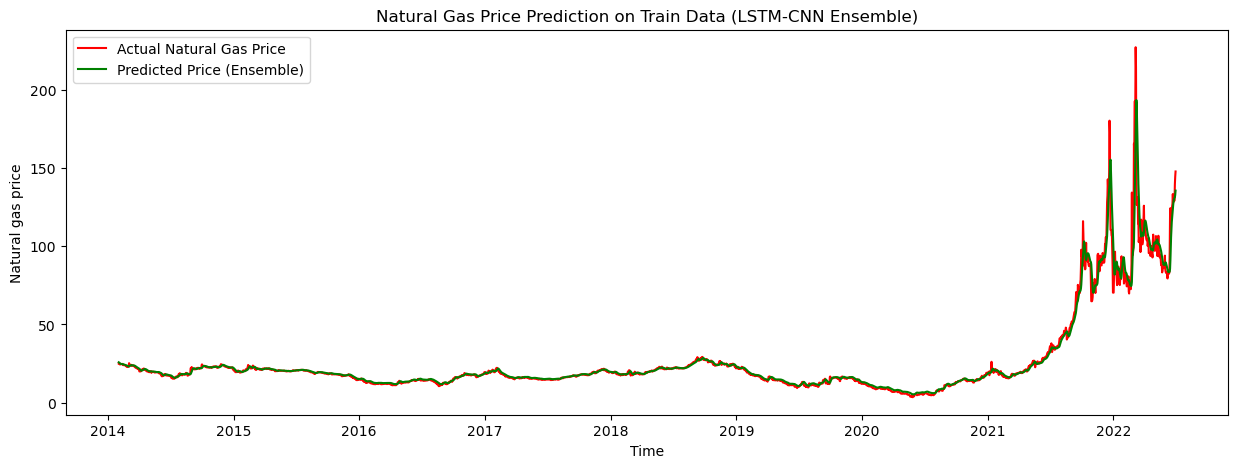

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test comparison (Ensemble):
            gas_price  gp_pred_ensemble
date                                   
2024-01-01     32.350         33.234344
2024-01-02     30.572         32.929768
2024-01-03     32.795         32.516968
            gas_price  gp_pred_ensemble
date                                   
2024-12-29     47.731         45.740330
2024-12-30     47.633         46.254494
2024-12-31     48.889         46.677143


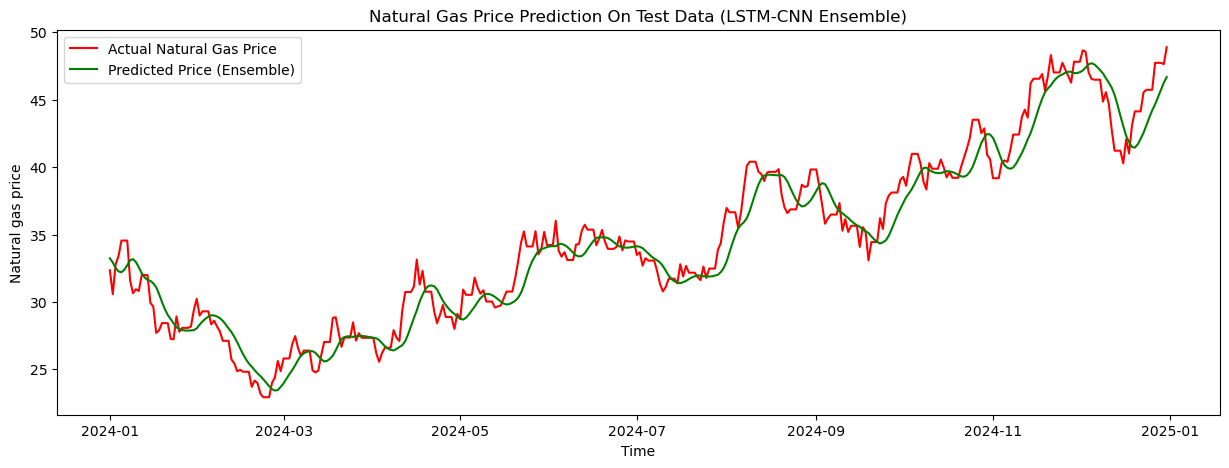

LSTM-CNN Ensemble Results:
Train Data:
MSE: 22.407326, RMSE: 4.7336, R²: 0.9648
Test Data:
MSE: 2.418053, RMSE: 1.5550, R²: 0.9424


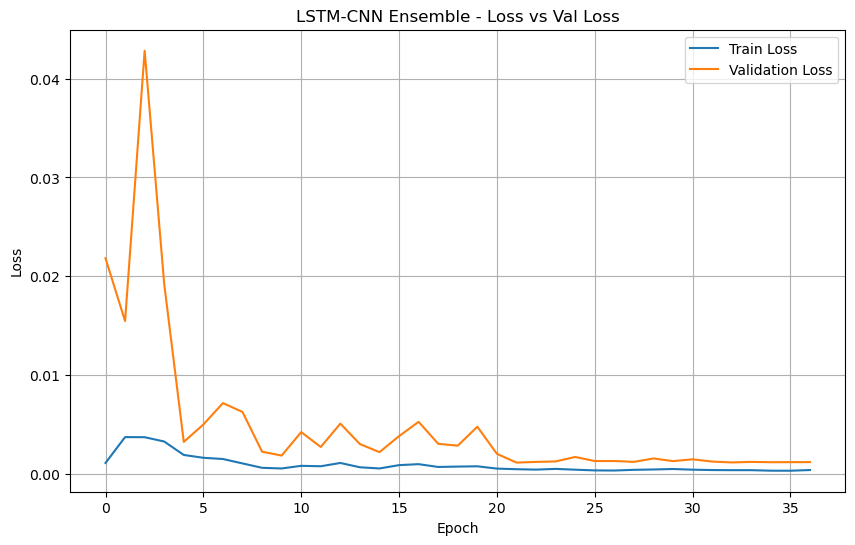


=== MODEL COMPARISON SUMMARY ===
Original LSTM:
Train Data: MSE: 21.5021, R²: 0.9662
Test Data:  MSE: 2.3958, R²: 0.9429

LSTM-CNN Ensemble:
Train Data: MSE: 22.4073, R²: 0.9648
Test Data:  MSE: 2.4181, R²: 0.9424

Improvement (Test R²): -0.0005


In [73]:
# LSTM-CNN-1 Ensemble Model
print("\n=== LSTM-CNN-1 ENSEMBLE MODEL ===")

# Build LSTM-CNN Ensemble model
ensemble_model = tf.keras.Sequential()

# CNN preprocessing
ensemble_model.add(tf.keras.layers.Conv1D(filters=50, kernel_size=3, activation='tanh', input_shape=(slot, 1), padding='same'))
ensemble_model.add(tf.keras.layers.Dropout(0.3))

# LSTM for temporal dependencies
ensemble_model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
ensemble_model.add(tf.keras.layers.Dropout(0.3))
ensemble_model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
ensemble_model.add(tf.keras.layers.Dropout(0.3))
ensemble_model.add(tf.keras.layers.LSTM(units=50, return_sequences=False))
ensemble_model.add(tf.keras.layers.Dropout(0.3))

# Dense output layer
ensemble_model.add(tf.keras.layers.Dense(units=1))

ensemble_model.compile(loss='mean_squared_error', optimizer='adam')
ensemble_model.summary()

# Train LSTM-CNN Ensemble model
early_stopping_ensemble = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr_ensemble = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

history_ensemble = ensemble_model.fit(
    x_train_univ, y_train_univ,
    validation_data=(x_val_univ, y_val_univ),
    epochs=100, batch_size=32, verbose=1, shuffle=False,
    callbacks=[early_stopping_ensemble, reduce_lr_ensemble]
)

# Model Evaluation - Train Data (Ensemble)
print("\n=== ENSEMBLE MODEL EVALUATION ===")
yp_train_ensemble = ensemble_model.predict(x_train_univ)

# INVERSE TRANSFORM to original scale
yp_train_ensemble_rescaled = scaler.inverse_transform(yp_train_ensemble)
y_train_rescaled = scaler.inverse_transform(y_train_univ.reshape(-1, 1))

train_compare_ensemble = pd.DataFrame({
    'gas_price': y_train_rescaled.flatten(),
    'gp_pred_ensemble': yp_train_ensemble_rescaled.flatten()
}, index=train.index[slot:val_split_idx])

print("Train comparison (Ensemble):")
print(train_compare_ensemble.head(3))
print(train_compare_ensemble.tail(3))

# Plot training results (Ensemble)
plt.figure(figsize=(15, 5))
plt.plot(train_compare_ensemble['gas_price'], color='red', label="Actual Natural Gas Price")
plt.plot(train_compare_ensemble['gp_pred_ensemble'], color='green', label='Predicted Price (Ensemble)')
plt.title("Natural Gas Price Prediction on Train Data (LSTM-CNN Ensemble)")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc='best')
plt.show()

# Test Data Evaluation (Ensemble - with same scaling approach)
dataset_total_scaled = np.vstack((train_scaled, test_scaled))
inputs = dataset_total_scaled[len(dataset_total_scaled) - len(test_scaled) - slot:]
x_test = []
for i in range(slot, len(test_scaled) + slot):
    x_test.append(inputs[i-slot:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
pred_price_ensemble = ensemble_model.predict(x_test)

# INVERSE TRANSFORM to original scale
pred_price_ensemble_rescaled = scaler.inverse_transform(pred_price_ensemble)

b_ensemble = pd.DataFrame(pred_price_ensemble_rescaled, columns=['gp_pred_ensemble'])
b_ensemble.index = test.index
test_compare_ensemble = pd.concat([test, b_ensemble], axis=1)

print("Test comparison (Ensemble):")
print(test_compare_ensemble.head(3))
print(test_compare_ensemble.tail(3))

# Plot test results (Ensemble)
plt.figure(figsize=(15,5))
plt.plot(test_compare_ensemble['gas_price'], color='red', label="Actual Natural Gas Price")
plt.plot(test_compare_ensemble['gp_pred_ensemble'], color='green', label='Predicted Price (Ensemble)')
plt.title("Natural Gas Price Prediction On Test Data (LSTM-CNN Ensemble)")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc='best')
plt.show()

# Calculate metrics (Ensemble)
mse_train_ensemble = mean_squared_error(train_compare_ensemble['gas_price'], train_compare_ensemble['gp_pred_ensemble'])
mse_test_ensemble = mean_squared_error(test_compare_ensemble['gas_price'], test_compare_ensemble['gp_pred_ensemble'])
rmse_train_ensemble = sqrt(mse_train_ensemble)
rmse_test_ensemble = sqrt(mse_test_ensemble)
r2_train_ensemble = r2_score(train_compare_ensemble['gas_price'], train_compare_ensemble['gp_pred_ensemble'])
r2_test_ensemble = r2_score(test_compare_ensemble['gas_price'], test_compare_ensemble['gp_pred_ensemble'])

print("LSTM-CNN Ensemble Results:")
print("Train Data:\nMSE: {:.6f}, RMSE: {:.4f}, R²: {:.4f}".format(mse_train_ensemble, rmse_train_ensemble, r2_train_ensemble))
print("Test Data:\nMSE: {:.6f}, RMSE: {:.4f}, R²: {:.4f}".format(mse_test_ensemble, rmse_test_ensemble, r2_test_ensemble))

# Plot training vs validation loss (Ensemble)
plt.figure(figsize=(10, 6))
plt.plot(history_ensemble.history['loss'], label='Train Loss')
plt.plot(history_ensemble.history['val_loss'], label='Validation Loss')
plt.title('LSTM-CNN Ensemble - Loss vs Val Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Comparison Summary
print("\n=== MODEL COMPARISON SUMMARY ===")
print("Original LSTM:")
print("Train Data: MSE: {:.4f}, R²: {:.4f}".format(mse_train, r2_train))
print("Test Data:  MSE: {:.4f}, R²: {:.4f}".format(mse_test, r2_test))
print("\nLSTM-CNN Ensemble:")
print("Train Data: MSE: {:.4f}, R²: {:.4f}".format(mse_train_ensemble, r2_train_ensemble))
print("Test Data:  MSE: {:.4f}, R²: {:.4f}".format(mse_test_ensemble, r2_test_ensemble))
print("\nImprovement (Test R²): {:.4f}".format(r2_test_ensemble - r2_test))

# Second Ensemble (CNN + LSTM)


=== CNN-LSTM-2 Ensemble Model ===


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_73 (Conv1D)              │ (None, 28, 50)         │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_183 (Dropout)           │ (None, 28, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_74 (Conv1D)              │ (None, 26, 50)         │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_184 (Dropout)           │ (None, 26, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_75 (Conv1D)              │ (None, 24, 50)         │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_185 (Dropout)           │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_110 (LSTM)                 │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_186 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,551 (138.87 KB)

 Trainable params: 35,551 (138.87 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.1974e-04 - val_loss: 0.0106 - learning_rate: 0.0010
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0026 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8626e-04 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.1165e-04 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.1807e-04 - val_loss: 0.0098 - learning_rate: 0.0010
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.3890e-04 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7610e-04 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 9/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.7499e-04 - val_loss: 0.0099 - learning_rate

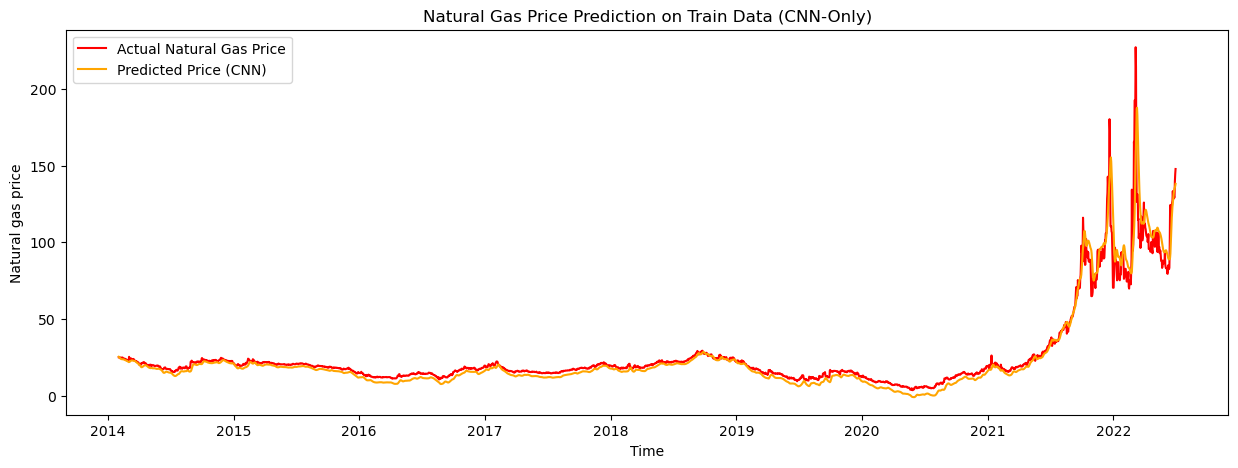

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Test comparison (CNN-LSTM-2 Ensemble):
            gas_price  gp_pred_cnn
date                              
2024-01-01     32.350    34.287270
2024-01-02     30.572    33.896030
2024-01-03     32.795    33.443298
            gas_price  gp_pred_cnn
date                              
2024-12-29     47.731    48.007355
2024-12-30     47.633    48.611057
2024-12-31     48.889    49.159874


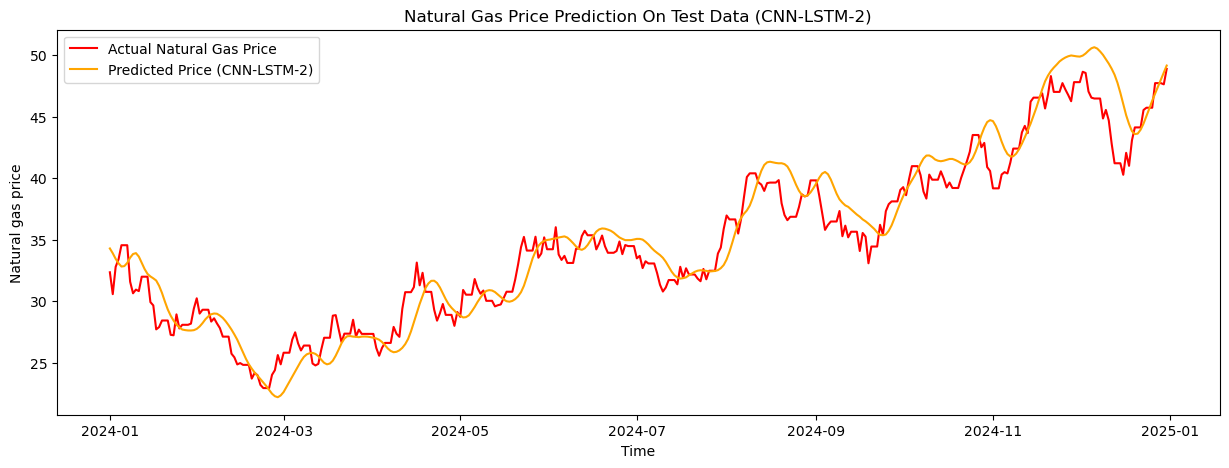

CNN-LSTM-2 Results:
Train Data:
MSE: 38.757689, RMSE: 6.2256, R²: 0.9390
Test Data:
MSE: 4.055447, RMSE: 2.0138, R²: 0.9034


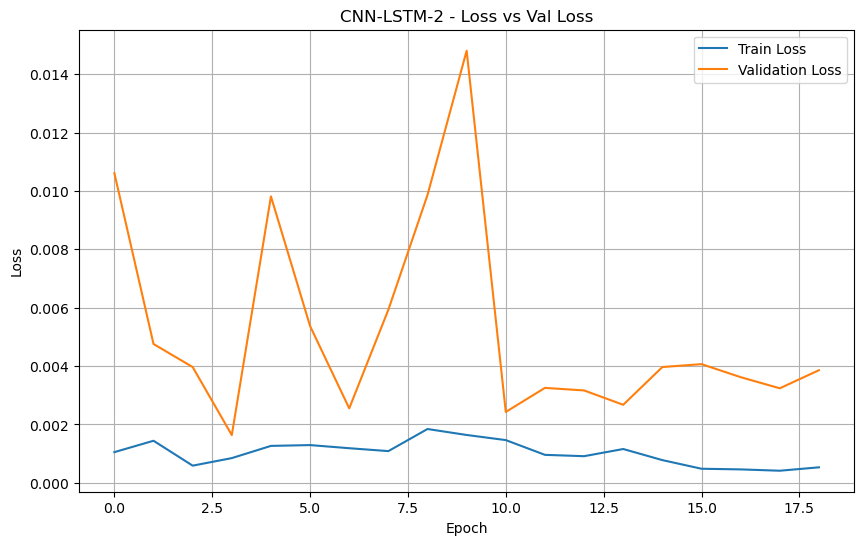


=== UPDATED MODEL COMPARISON SUMMARY ===
Original LSTM:
Train Data: MSE: 21.5021, R²: 0.9662
Test Data:  MSE: 2.3958, R²: 0.9429

CNN-LSTM-2 Ensemble:
Train Data: MSE: 38.7577, R²: 0.9390
Test Data:  MSE: 4.0554, R²: 0.9034

CNN-LSTM-2 Ensemble vs LSTM (Test R² difference): -0.0395


In [75]:
# CNN-LSTM-2 Ensemble Model
print("\n=== CNN-LSTM-2 Ensemble Model ===")

# Build CNN-LSTM-2 Ensemble model
cnn_model = tf.keras.Sequential()

# CNN layers for pattern detection and feature extraction
cnn_model.add(tf.keras.layers.Conv1D(filters=50, kernel_size=3, activation='tanh', input_shape=(slot, 1)))
cnn_model.add(tf.keras.layers.Dropout(0.3))
cnn_model.add(tf.keras.layers.Conv1D(filters=50, kernel_size=3, activation='tanh'))
cnn_model.add(tf.keras.layers.Dropout(0.3))
cnn_model.add(tf.keras.layers.Conv1D(filters=50, kernel_size=3, activation='tanh'))
cnn_model.add(tf.keras.layers.Dropout(0.3))

# LSTM for time sequence
cnn_model.add(tf.keras.layers.LSTM(units=50, return_sequences=False))
cnn_model.add(tf.keras.layers.Dropout(0.3))
cnn_model.add(tf.keras.layers.Dense(units=1))

cnn_model.compile(loss='mean_squared_error', optimizer='adam')
cnn_model.summary()

# Train CNN-LSTM-2 Ensemble model
early_stopping_cnn = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr_cnn = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

history_cnn = cnn_model.fit(
    x_train_univ, y_train_univ,
    validation_data=(x_val_univ, y_val_univ),
    epochs=100, batch_size=32, verbose=1, shuffle=False,
    callbacks=[early_stopping_cnn, reduce_lr_cnn]
)

# Model Evaluation - Train Data (CNN-LSTM-2 Ensemble)
print("\n=== CNN-LSTM-2 Ensemble Model EVALUATION ===")
yp_train_cnn = cnn_model.predict(x_train_univ)

# INVERSE TRANSFORM to original scale
yp_train_cnn_rescaled = scaler.inverse_transform(yp_train_cnn)
y_train_rescaled = scaler.inverse_transform(y_train_univ.reshape(-1, 1))

train_compare_cnn = pd.DataFrame({
    'gas_price': y_train_rescaled.flatten(),
    'gp_pred_cnn': yp_train_cnn_rescaled.flatten()
}, index=train.index[slot:val_split_idx])

print("Train comparison (CNN-LSTM-2):")
print(train_compare_cnn.head(3))
print(train_compare_cnn.tail(3))

# Plot training results (CNN-LSTM-2 Ensemble)
plt.figure(figsize=(15, 5))
plt.plot(train_compare_cnn['gas_price'], color='red', label="Actual Natural Gas Price")
plt.plot(train_compare_cnn['gp_pred_cnn'], color='orange', label='Predicted Price (CNN)')
plt.title("Natural Gas Price Prediction on Train Data (CNN-Only)")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc='best')
plt.show()

# Test Data Evaluation (CNN-LSTM-2 Ensemble)
dataset_total_scaled = np.vstack((train_scaled, test_scaled))
inputs = dataset_total_scaled[len(dataset_total_scaled) - len(test_scaled) - slot:]
x_test = []
for i in range(slot, len(test_scaled) + slot):
    x_test.append(inputs[i-slot:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
pred_price_cnn = cnn_model.predict(x_test)

# INVERSE TRANSFORM to original scale
pred_price_cnn_rescaled = scaler.inverse_transform(pred_price_cnn)

b_cnn = pd.DataFrame(pred_price_cnn_rescaled, columns=['gp_pred_cnn'])
b_cnn.index = test.index
test_compare_cnn = pd.concat([test, b_cnn], axis=1)

print("Test comparison (CNN-LSTM-2 Ensemble):")
print(test_compare_cnn.head(3))
print(test_compare_cnn.tail(3))

# Plot test results (CNN-LSTM-2 Ensemble)
plt.figure(figsize=(15,5))
plt.plot(test_compare_cnn['gas_price'], color='red', label="Actual Natural Gas Price")
plt.plot(test_compare_cnn['gp_pred_cnn'], color='orange', label='Predicted Price (CNN-LSTM-2)')
plt.title("Natural Gas Price Prediction On Test Data (CNN-LSTM-2)")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc='best')
plt.show()

# Calculate metrics (CNN-LSTM-2 Ensemble)
mse_train_cnn = mean_squared_error(train_compare_cnn['gas_price'], train_compare_cnn['gp_pred_cnn'])
mse_test_cnn = mean_squared_error(test_compare_cnn['gas_price'], test_compare_cnn['gp_pred_cnn'])
rmse_train_cnn = sqrt(mse_train_cnn)
rmse_test_cnn = sqrt(mse_test_cnn)
r2_train_cnn = r2_score(train_compare_cnn['gas_price'], train_compare_cnn['gp_pred_cnn'])
r2_test_cnn = r2_score(test_compare_cnn['gas_price'], test_compare_cnn['gp_pred_cnn'])

print("CNN-LSTM-2 Results:")
print("Train Data:\nMSE: {:.6f}, RMSE: {:.4f}, R²: {:.4f}".format(mse_train_cnn, rmse_train_cnn, r2_train_cnn))
print("Test Data:\nMSE: {:.6f}, RMSE: {:.4f}, R²: {:.4f}".format(mse_test_cnn, rmse_test_cnn, r2_test_cnn))

# Plot training vs validation loss (CNN-LSTM-2 Ensemble)
plt.figure(figsize=(10, 6))
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('CNN-LSTM-2 - Loss vs Val Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Updated Comparison Summary
print("\n=== UPDATED MODEL COMPARISON SUMMARY ===")
print("Original LSTM:")
print("Train Data: MSE: {:.4f}, R²: {:.4f}".format(mse_train, r2_train))
print("Test Data:  MSE: {:.4f}, R²: {:.4f}".format(mse_test, r2_test))
print("\nCNN-LSTM-2 Ensemble:")
print("Train Data: MSE: {:.4f}, R²: {:.4f}".format(mse_train_cnn, r2_train_cnn))
print("Test Data:  MSE: {:.4f}, R²: {:.4f}".format(mse_test_cnn, r2_test_cnn))
print("\nCNN-LSTM-2 Ensemble vs LSTM (Test R² difference): {:.4f}".format(r2_test_cnn - r2_test))

## CNN-LSTM Ensemble Models

### Architectures Explored:

Two ensemble variants were constructed to investigate whether combining convolutional feature extraction with temporal modeling improves forecasting performance:

- **LSTM-CNN (Type 1)**: Begins with a convolutional layer to extract short-term features, followed by stacked LSTM layers to model sequential dependencies.
- **CNN-LSTM (Type 2)**: Leverages multiple convolutional layers before passing the extracted features into a single LSTM layer for temporal interpretation.

### Performance Summary:
- **LSTM-CNN**: Test R² ≈ 0.9424 (similar to pure LSTM)
- **CNN-LSTM**: Test R² ≈ 0.9034 (slightly inferior)

These ensemble designs are still undergoing active tuning, particularly with respect to the number of units. While initial results suggest modest improvement (or in some cases, degradation), it’s important to recognize that:
- Deeper architectural tuning (e.g., filter sizes, stacking, hybrid regularization) could unlock stronger forecasting capabilities.
- The goal of this pipeline is not to optimize forecasting accuracy per se, but rather to develop a robust framework whose outputs serve as inputs to a reinforcement learning (RL) hedging agent.

The marginal gains from ensemble architectures may reflect the already high autocorrelation structure of the TTF price series, which LSTMs alone can exploit effectively. Nevertheless, CNN-LSTM hybrids may prove advantageous in multivariate contexts (next step).

# Multivariate Models


=== EXOGENOUS FEATURES TESTING ===
x_train_multi: (3219, 7, 12), x_val_multi: (54, 7, 12)

=== CORRELATION MATRIX OF FEATURES ===

Correlation matrix (top 10 gas_price correlations):
gas_price           1.000000
GPRD_THREAT         0.298378
GPRD                0.257350
VIX_USD             0.252817
GPRD_ACT            0.154670
Full_EU_sum         0.099794
Injection_EU_SUM    0.098514
Storage_EU_sum      0.073509
HDD_EU_avg         -0.006705
Exp_EU_sum         -0.304584
Name: gas_price, dtype: float64


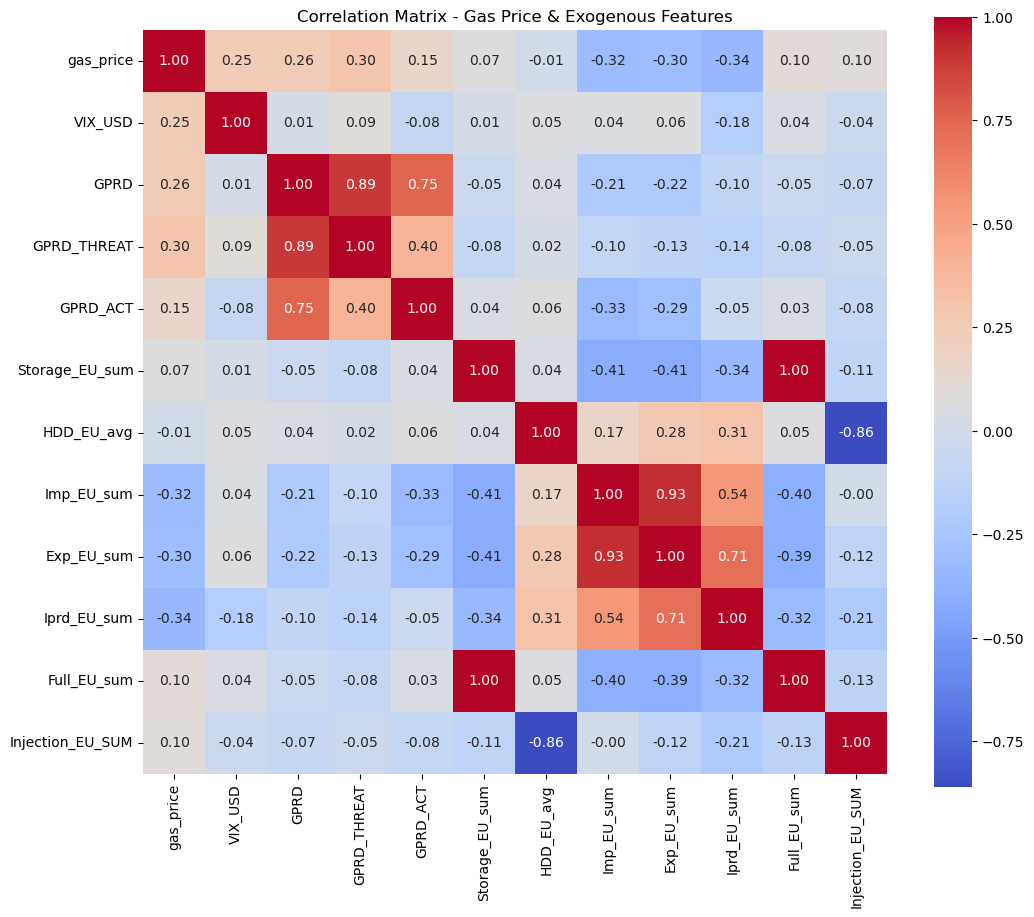

In [77]:
# ===== EXOGENOUS FEATURES TESTING =====
print("\n=== EXOGENOUS FEATURES TESTING ===")

# Load exogenous data
exog_data = pd.read_csv("/Users/gio/Desktop/TRINITY COLLEGE/DISSERTATION/New proposal/data/Reinforcement_Learning/regime/data_regime.csv")
exog_data['Date'] = pd.to_datetime(exog_data['Date'], format="%d/%m/%Y")
exog_data = exog_data.set_index('Date').sort_index()

# Multivariate sequences
def create_multivariate_sequences(data, slot):
    x, y = [], []
    for i in range(slot, len(data)):
        x.append(data[i-slot:i, :])
        y.append(data[i, 0])  # Gas price è la prima colonna
    return np.array(x), np.array(y)

# Select key exogenous variables
exog_features = ['VIX_USD', 'GPRD', 'GPRD_THREAT', 'GPRD_ACT', 
                 'Storage_EU_sum', 'HDD_EU_avg', 'Imp_EU_sum', 'Exp_EU_sum', 'Iprd_EU_sum', 'Full_EU_sum', 'Injection_EU_SUM']

# Merge with original data
merged_data = pd.merge(data, exog_data[exog_features], left_index=True, right_index=True, how='inner')

# Prepare multivariate data
train_merged = merged_data[merged_data.index <= '2023-12-31']
test_merged = merged_data[merged_data.index >= '2024-01-01']

val_split_date = '2023-10-31'
train_merged_partial = train_merged[train_merged.index <= val_split_date]
val_merged = train_merged[(train_merged.index > val_split_date) & (train_merged.index <= '2023-12-31')]

scaler_partial = MinMaxScaler()
train_scaled_partial = scaler_partial.fit_transform(train_merged_partial.values)
val_scaled = scaler_partial.transform(val_merged.values)

x_train_multi, y_train_multi = create_multivariate_sequences(train_scaled_partial, slot)
x_val_multi, y_val_multi = create_multivariate_sequences(val_scaled, slot)

# Scale all features
from sklearn.preprocessing import MinMaxScaler
scaler_multi = MinMaxScaler(feature_range=(0, 1))
train_scaled_multi = scaler_multi.fit_transform(train_merged.values)
test_scaled_multi = scaler_multi.transform(test_merged.values)

# Prepare sequences for multivariate models
# === MULTIVARIATE TRAIN / VALIDATION SPLIT ===

slot = 7
n_features = train_scaled_multi.shape[1]

# Split
val_split_date = '2023-10-31'
train_merged_partial = train_merged[train_merged.index <= val_split_date]
val_merged = train_merged[(train_merged.index > val_split_date) & (train_merged.index <= '2023-12-31')]

# Scaling
scaler_partial_multi = MinMaxScaler()
train_scaled_partial_multi = scaler_partial_multi.fit_transform(train_merged_partial.values)
val_scaled_multi = scaler_partial_multi.transform(val_merged.values)

# Function
def create_multivariate_sequences(data, slot):
    x, y = [], []
    for i in range(slot, len(data)):
        x.append(data[i-slot:i, :])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

x_train_multi, y_train_multi = create_multivariate_sequences(train_scaled_partial_multi, slot)
x_val_multi, y_val_multi = create_multivariate_sequences(val_scaled_multi, slot)

print(f"x_train_multi: {x_train_multi.shape}, x_val_multi: {x_val_multi.shape}")

# === CORRELATION MATRIX ===
print("\n=== CORRELATION MATRIX OF FEATURES ===")
corr_matrix = merged_data.corr()

# numerical values
print("\nCorrelation matrix (top 10 gas_price correlations):")
print(corr_matrix['gas_price'].sort_values(ascending=False).head(10))

# heatmap 
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix - Gas Price & Exogenous Features")
plt.show()



## Multivariate Feature Integration

### Selected Variables:
- **Financial Risk**: VIX_USD (market volatility)
- **Geopolitical**: GPRD, GPRD_THREAT, GPRD_ACT
- **Infrastructure**: Storage_EU_sum, Imp_EU_sum, Exp_EU_sum
- **Weather**: HDD_EU_avg (heating degree days)
- **Market Structure**: Injection_EU_SUM, Full_EU_sum, Iprd_EU_sum

The multivariate approach draws from economic intuition regarding the fundamental drivers of gas prices. While overall correlations between these features and the target are moderate, this is a deliberate choice. Given the extremely high autocorrelation of the TTF gas price, including highly correlated exogenous features (e.g., Brent Oil, API2 Coal) could introduce redundancy or noise rather than meaningful signal.

Instead, the selected variables aim to contribute complementary information — features that are not strongly collinear with the target but are theoretically relevant. Several combinations have been tested, and further iterations remain possible.

In [79]:
# Build multivariate models
print("\n--- Building Multivariate Models ---")

# Multivariate LSTM
lstm_multi = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=50, input_shape=(slot, n_features), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])
lstm_multi.compile(loss='mean_squared_error', optimizer='adam')

# Multivariate CNN-LSTM Ensemble
cnn_multi = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=50, kernel_size=3, activation='tanh', input_shape=(slot, n_features), padding='same'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters=50, kernel_size=3, activation='tanh', padding='same'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters=50, kernel_size=3, activation='tanh', padding='same'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50, return_sequences=False),  # stessa struttura del modello univariato
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])
cnn_multi.compile(loss='mean_squared_error', optimizer='adam')

# Multivariate LSTM-CNN Ensemble
ensemble_multi = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=50, kernel_size=3, activation='tanh', input_shape=(slot, n_features)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters=50, kernel_size=3, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=50, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])
ensemble_multi.compile(loss='mean_squared_error', optimizer='adam')

# Train multivariate models
print("\n--- Training Multivariate Models ---")

# CALLBACKS - Multivariate LSTM
early_stopping_multi_lstm = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr_multi_lstm = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

# CALLBACKS - Multivariate CNN-LSTM Ensemble
early_stopping_multi_cnn = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr_multi_cnn = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

# CALLBACKS - Multivariate LSTM-CNN Ensemble
early_stopping_multi_ens = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr_multi_ens = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

print("Training Multivariate LSTM...")
lstm_multi.fit(
    x_train_multi, y_train_multi,
    validation_data=(x_val_multi, y_val_multi),
    epochs=100, batch_size=32, verbose=0,
    callbacks=[early_stopping_multi_lstm, reduce_lr_multi_lstm]
)

print("Training Multivariate CNN-LSTM Ensemble...")
cnn_multi.fit(
    x_train_multi, y_train_multi,
    validation_data=(x_val_multi, y_val_multi),
    epochs=100, batch_size=32, verbose=0,
    callbacks=[early_stopping_multi_cnn, reduce_lr_multi_cnn]
)

print("Training Multivariate LSTM-CNN Ensemble...")
ensemble_multi.fit(
    x_train_multi, y_train_multi,
    validation_data=(x_val_multi, y_val_multi),
    epochs=100, batch_size=32, verbose=0,
    callbacks=[early_stopping_multi_ens, reduce_lr_multi_ens]
)


# Prepare test data for multivariate models
dataset_total_multi = np.vstack((train_scaled_multi, test_scaled_multi))
inputs_multi = scaler_multi.transform(merged_data[-(len(test_scaled_multi) + slot):].values)
x_test_multi = []
for i in range(slot, len(test_scaled_multi) + slot):
    x_test_multi.append(inputs_multi[i-slot:i, :])
x_test_multi = np.array(x_test_multi)

# Evaluate multivariate models
def evaluate_multivariate_model(model, x_train, y_train, x_test, model_name):
    from math import sqrt
    y_pred_train = model.predict(x_train, verbose=0).flatten()
    r2_train = r2_score(y_train, y_pred_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = sqrt(mse_train)

    y_pred_test = model.predict(x_test, verbose=0).flatten()
    y_test_scaled = test_scaled_multi[:, 0]
    r2_test = r2_score(y_test_scaled, y_pred_test)
    mse_test = mean_squared_error(y_test_scaled, y_pred_test)
    rmse_test = sqrt(mse_test)

    print(f"\n{model_name} (Multivariate):")
    print(f"Train - R²: {r2_train:.4f}, MSE: {mse_train:.6f}, RMSE: {rmse_train:.4f}")
    print(f"Test  - R²: {r2_test:.4f}, MSE: {mse_test:.6f}, RMSE: {rmse_test:.4f}")

    return {
        'train_r2': r2_train, 'train_mse': mse_train, 'train_rmse': rmse_train,
        'test_r2': r2_test, 'test_mse': mse_test, 'test_rmse': rmse_test
    }

# Evaluate all multivariate models
results_lstm_multi = evaluate_multivariate_model(lstm_multi, x_train_multi, y_train_multi, x_test_multi, "LSTM")
results_cnn_multi = evaluate_multivariate_model(cnn_multi, x_train_multi, y_train_multi, x_test_multi, "CNN")
results_ensemble_multi = evaluate_multivariate_model(ensemble_multi, x_train_multi, y_train_multi, x_test_multi, "Ensemble")

# === RESCALE MULTIVARIATE PREDICTIONS TO ORIGINAL SCALE ===
print("\n=== RESCALED MULTIVARIATE METRICS (COMPARABLE WITH UNIVARIATE) ===")

def inverse_multivariate_predictions(y_pred_scaled, y_true_scaled, scaler, feature_index=0):
    dummy = np.zeros((len(y_pred_scaled), scaler.n_features_in_))
    dummy[:, feature_index] = y_true_scaled
    y_true_rescaled = scaler.inverse_transform(dummy)[:, feature_index]
    dummy[:, feature_index] = y_pred_scaled
    y_pred_rescaled = scaler.inverse_transform(dummy)[:, feature_index]
    return y_true_rescaled, y_pred_rescaled

# scaled target
y_test_scaled_multi = test_scaled_multi[:, 0]

# LSTM
y_pred_lstm_scaled = lstm_multi.predict(x_test_multi, verbose=0).flatten()
y_true_lstm, y_pred_lstm = inverse_multivariate_predictions(y_pred_lstm_scaled, y_test_scaled_multi, scaler_multi)
mse_test_lstm_rescaled = mean_squared_error(y_true_lstm, y_pred_lstm)
rmse_test_lstm_rescaled = sqrt(mse_test_lstm_rescaled)
r2_test_lstm_rescaled = r2_score(y_true_lstm, y_pred_lstm)

# CNN-LSTM Ensemble
y_pred_cnn_scaled = cnn_multi.predict(x_test_multi, verbose=0).flatten()
y_true_cnn, y_pred_cnn = inverse_multivariate_predictions(y_pred_cnn_scaled, y_test_scaled_multi, scaler_multi)
mse_test_cnn_rescaled = mean_squared_error(y_true_cnn, y_pred_cnn)
rmse_test_cnn_rescaled = sqrt(mse_test_cnn_rescaled)
r2_test_cnn_rescaled = r2_score(y_true_cnn, y_pred_cnn)

# LSTM-CNN Ensemble
y_pred_ens_scaled = ensemble_multi.predict(x_test_multi, verbose=0).flatten()
y_true_ens, y_pred_ens = inverse_multivariate_predictions(y_pred_ens_scaled, y_test_scaled_multi, scaler_multi)
mse_test_ens_rescaled = mean_squared_error(y_true_ens, y_pred_ens)
rmse_test_ens_rescaled = sqrt(mse_test_ens_rescaled)
r2_test_ens_rescaled = r2_score(y_true_ens, y_pred_ens)

# Print metrics
print(f"LSTM Multi (rescaled):     R²: {r2_test_lstm_rescaled:.4f}, MSE: {mse_test_lstm_rescaled:.4f}, RMSE: {rmse_test_lstm_rescaled:.4f}")
print(f"CNN-LSTM Ensemble Multi (rescaled):      R²: {r2_test_cnn_rescaled:.4f}, MSE: {mse_test_cnn_rescaled:.4f}, RMSE: {rmse_test_cnn_rescaled:.4f}")
print(f"LSTM-CNN Ensemble Multi (rescaled): R²: {r2_test_ens_rescaled:.4f}, MSE: {mse_test_ens_rescaled:.4f}, RMSE: {rmse_test_ens_rescaled:.4f}")


--- Building Multivariate Models ---

--- Training Multivariate Models ---
Training Multivariate LSTM...
Training Multivariate CNN-LSTM Ensemble...
Training Multivariate LSTM-CNN Ensemble...

LSTM (Multivariate):
Train - R²: 0.9766, MSE: 0.000371, RMSE: 0.0193
Test  - R²: 0.8807, MSE: 0.000044, RMSE: 0.0067

CNN (Multivariate):
Train - R²: 0.9851, MSE: 0.000237, RMSE: 0.0154
Test  - R²: 0.9222, MSE: 0.000029, RMSE: 0.0054

Ensemble (Multivariate):
Train - R²: 0.9817, MSE: 0.000291, RMSE: 0.0171
Test  - R²: 0.8970, MSE: 0.000038, RMSE: 0.0062

=== RESCALED MULTIVARIATE METRICS (COMPARABLE WITH UNIVARIATE) ===
LSTM Multi (rescaled):     R²: 0.8807, MSE: 5.0102, RMSE: 2.2383
CNN-LSTM Ensemble Multi (rescaled):      R²: 0.9222, MSE: 3.2684, RMSE: 1.8079
LSTM-CNN Ensemble Multi (rescaled): R²: 0.8970, MSE: 4.3246, RMSE: 2.0796


## Multivariate Model Results

### Architecture Adaptations:
- **Reduced Dropout**: 20% (different values were tested)
- **Preserved Structure**: Same layer configurations

### Performance Results:
- **LSTM Multi**: Test R² = 0.8807, RMSE = 2.2383
- **CNN-LSTM Multi**: Test R² = 0.9222, RMSE = 1.8079 (best multivariate)
- **LSTM-CNN Multi**: Test R² = 0.8970, RMSE = 2.0796

Despite incorporating theoretically relevant variables, multivariate models generally underperform univariate counterparts. This suggests that the strong autocorrelation of gas prices already captures much of the predictive structure.
The addition of exogenous variables introduces noise in the pure LSTM and the ensemble model with a single CNN layer. However, performance significantly improves in the CNN-LSTM model with three convolutional layers, suggesting that deeper architectures may be better suited to extract relevant patterns from exogenous signals.

This result highlights that features with low linear correlation to gas prices can still carry valuable information when properly encoded. Further architectural tuning (e.g., different kernel sizes, attention mechanisms, or temporal convolutions) might amplify this advantage. Ultimately, the goal is not just improved forecasting, but the construction of a generalizable modeling pipeline — and this behavior is promising in the context of downstream reinforcement learning for hedging.


# Random Forest Regressor for Feature Importance


=== RANDOM FOREST REGRESSOR FOR FEATURE IMPORTANCE ===

Random Forest Regressor (Day-Ahead, Multivariate):
Train - MSE: 4.019284, RMSE: 2.0048
Test  - MSE: 249.403079, RMSE: 15.7925

Top Feature Importances (Random Forest):
                 feature  importance
8               GPRD_t-6    0.206940
19       GPRD_THREAT_t-2    0.070980
7               GPRD_t-7    0.063209
30    Storage_EU_sum_t-5    0.051763
41        HDD_EU_avg_t-1    0.036028
72  Injection_EU_SUM_t-5    0.031272
0            VIX_USD_t-7    0.028742
66       Full_EU_sum_t-4    0.028225
74  Injection_EU_SUM_t-3    0.027237
44        Imp_EU_sum_t-5    0.026547
63       Full_EU_sum_t-7    0.021646
18       GPRD_THREAT_t-3    0.021544
73  Injection_EU_SUM_t-4    0.020217
55        Exp_EU_sum_t-1    0.019569
5            VIX_USD_t-2    0.015988


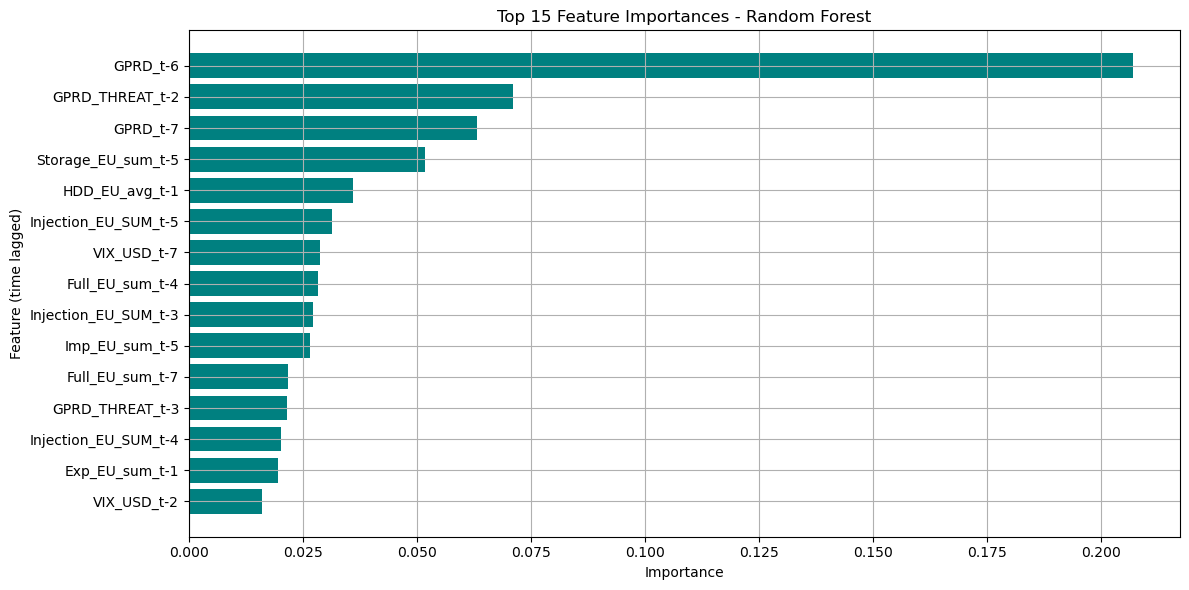

In [81]:
print("\n=== RANDOM FOREST REGRESSOR FOR FEATURE IMPORTANCE ===")

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

# same dataset
slot_rf = slot 
target_col = 'gas_price'

# X and y for day ahead forecasting
def create_rf_features_targets(df, features, target_col, slot):
    X, y, dates = [], [], []
    for i in range(slot, len(df)):
        window = df[features].iloc[i-slot:i].values.flatten()
        target = df[target_col].iloc[i]
        X.append(window)
        y.append(target)
        dates.append(df.index[i])
    return np.array(X), np.array(y), dates

# merged_data
X_all_rf, y_all_rf, all_dates_rf = create_rf_features_targets(merged_data, exog_features, 'gas_price', slot_rf)
dates_rf = pd.Series(all_dates_rf)

# Split
train_idx_rf = dates_rf <= '2023-12-31'
test_idx_rf = dates_rf >= '2024-01-01'

X_train_rf = X_all_rf[train_idx_rf]
y_train_rf = y_all_rf[train_idx_rf]
X_test_rf = X_all_rf[test_idx_rf]
y_test_rf = y_all_rf[test_idx_rf]

# Model archietcture
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Predictions
y_train_pred_rf = rf_model.predict(X_train_rf)
y_test_pred_rf = rf_model.predict(X_test_rf)

# Metrics
mse_train_rf = mean_squared_error(y_train_rf, y_train_pred_rf)
rmse_train_rf = sqrt(mse_train_rf)
mse_test_rf = mean_squared_error(y_test_rf, y_test_pred_rf)
rmse_test_rf = sqrt(mse_test_rf)

print(f"\nRandom Forest Regressor (Day-Ahead, Multivariate):")
print(f"Train - MSE: {mse_train_rf:.6f}, RMSE: {rmse_train_rf:.4f}")
print(f"Test  - MSE: {mse_test_rf:.6f}, RMSE: {rmse_test_rf:.4f}")

# Feature importance
importances = rf_model.feature_importances_

# Mapping
n_feats = len(exog_features)
expanded_feature_names = []
for f in exog_features:
    for s in range(slot_rf):
        expanded_feature_names.append(f"{f}_t-{slot_rf - s}")

# Organise features
feature_importance_df = pd.DataFrame({
    'feature': expanded_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nTop Feature Importances (Random Forest):")
print(feature_importance_df.head(15))

# Plot 
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['feature'][:15][::-1], feature_importance_df['importance'][:15][::-1], color='teal')
plt.title("Top 15 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature (time lagged)")
plt.tight_layout()
plt.grid(True)
plt.show()

## Feature Importance via Random Forest

In this pipeline, Random Forest is not employed for time series forecasting, but rather for feature relevance analysis.

Unlike LSTM or CNN models, Random Forest does not retain temporal memory and is incapable of understanding sequence-based dependencies. It treats each input observation independently and lacks awareness of ordering or time-lag relationships. 
However, Random Forest can be used to interpret feature contributions. When structured with lagged input windows, it can help quantify which exogenous variables are most influential in driving the model's output. 

In summary, Random Forest is deployed here not as a competitive forecaster, but as an interpretable diagnostic tool to better understand which variables may carry valuable information in the multivariate modeling framework.

In [83]:
# ===== COMPREHENSIVE COMPARISON =====
print("\n=== COMPREHENSIVE MODEL COMPARISON (ALL IN REAL SCALE) ===")

print("\n--- Univariate Models ---")
print(f"LSTM:     Train - R²: {r2_train:.4f}, MSE: {mse_train:.6f}, RMSE: {rmse_train:.4f} | "
      f"Test - R²: {r2_test:.4f}, MSE: {mse_test:.6f}, RMSE: {rmse_test:.4f}")
print(f"CNN-LSTM Ensemble:      Train - R²: {r2_train_cnn:.4f}, MSE: {mse_train_cnn:.6f}, RMSE: {rmse_train_cnn:.4f} | "
      f"Test - R²: {r2_test_cnn:.4f}, MSE: {mse_test_cnn:.6f}, RMSE: {rmse_test_cnn:.4f}")
print(f"LSTM-CNN Ensemble: Train - R²: {r2_train_ensemble:.4f}, MSE: {mse_train_ensemble:.6f}, RMSE: {rmse_train_ensemble:.4f} | "
      f"Test - R²: {r2_test_ensemble:.4f}, MSE: {mse_test_ensemble:.6f}, RMSE: {rmse_test_ensemble:.4f}")
print(f"ARIMA:    Train - R²: {r2_arima_train:.4f}, MSE: {mse_arima_train:.6f}, RMSE: {rmse_arima_train:.4f} | "
      f"Test - R²: {r2_arima_test:.4f}, MSE: {mse_arima_test:.6f}, RMSE: {rmse_arima_test:.4f}")

print("\n--- Multivariate Models ---")
print(f"LSTM Multi:     Test - R²: {r2_test_lstm_rescaled:.4f}, MSE: {mse_test_lstm_rescaled:.4f}, RMSE: {rmse_test_lstm_rescaled:.4f}")
print(f"CNN-LSTM Ensemble Multi:      Test - R²: {r2_test_cnn_rescaled:.4f}, MSE: {mse_test_cnn_rescaled:.4f}, RMSE: {rmse_test_cnn_rescaled:.4f}")
print(f"LSTM-CNN Ensemble Multi: Test - R²: {r2_test_ens_rescaled:.4f}, MSE: {mse_test_ens_rescaled:.4f}, RMSE: {rmse_test_ens_rescaled:.4f}")

print(f"\nExogenous features used: {exog_features}")


=== COMPREHENSIVE MODEL COMPARISON (ALL IN REAL SCALE) ===

--- Univariate Models ---
LSTM:     Train - R²: 0.9662, MSE: 21.502069, RMSE: 4.6370 | Test - R²: 0.9429, MSE: 2.395827, RMSE: 1.5478
CNN-LSTM Ensemble:      Train - R²: 0.9390, MSE: 38.757689, RMSE: 6.2256 | Test - R²: 0.9034, MSE: 4.055447, RMSE: 2.0138
LSTM-CNN Ensemble: Train - R²: 0.9648, MSE: 22.407326, RMSE: 4.7336 | Test - R²: 0.9424, MSE: 2.418053, RMSE: 1.5550
ARIMA:    Train - R²: 0.9916, MSE: 13.433612, RMSE: 3.6652 | Test - R²: 0.9811, MSE: 0.791681, RMSE: 0.8898

--- Multivariate Models ---
LSTM Multi:     Test - R²: 0.8807, MSE: 5.0102, RMSE: 2.2383
CNN-LSTM Ensemble Multi:      Test - R²: 0.9222, MSE: 3.2684, RMSE: 1.8079
LSTM-CNN Ensemble Multi: Test - R²: 0.8970, MSE: 4.3246, RMSE: 2.0796

Exogenous features used: ['VIX_USD', 'GPRD', 'GPRD_THREAT', 'GPRD_ACT', 'Storage_EU_sum', 'HDD_EU_avg', 'Imp_EU_sum', 'Exp_EU_sum', 'Iprd_EU_sum', 'Full_EU_sum', 'Injection_EU_SUM']


## Comprehensive Model Comparison


- **ARIMA** remains the most accurate model in terms of pure forecasting performance, especially on the test set (RMSE = 0.8898), benefiting from its ability to directly exploit the extreme autocorrelation structure of the TTF price series.
- Among deep learning approaches, the **LSTM univariate model** performs remarkably well, achieving Test RMSE = 1.5478 with relatively simple architecture and no exogenous variables.
- **Multivariate models** incorporating exogenous features show mixed results. While the pure **LSTM Multi** model suffers from noise introduced by additional variables, the **CNN-LSTM Ensemble Multi** variant outperforms its counterparts (Test RMSE = 1.8079), suggesting that deep CNN layers may be better equipped to extract structured signal from weakly correlated inputs.

The results highlight how high intrinsic autocorrelation in the TTF series favors autoregressive and univariate models. However, selective use of low-correlated exogenous signals, such as geopolitical indicators and weather factors, can improve performance when appropriately integrated (as seen in CNN-LSTM Multi).

It is important to note that the goal of this pipeline is not to optimize forecasting performance, but to provide a methodologically sound and explainable forecasting framework that will serve as input to a reinforcement learning hedging strategy in the second part of the project.

# Rollig Regime Classification


=== ROLLING REGIME CLASSIFICATION - BEST MODEL ===

Final regime-classified dataset:
                 date  gas_price  pred_price vol_regime dir_regime
date                                                              
2024-12-27 2024-12-27     47.731   45.808376       High       Bull
2024-12-28 2024-12-28     47.731   46.321239       High       Bull
2024-12-29 2024-12-29     47.731   46.863129       High       Bull
2024-12-30 2024-12-30     47.633   47.364265       High       Bull
2024-12-31 2024-12-31     48.889   47.767494       High       Bull


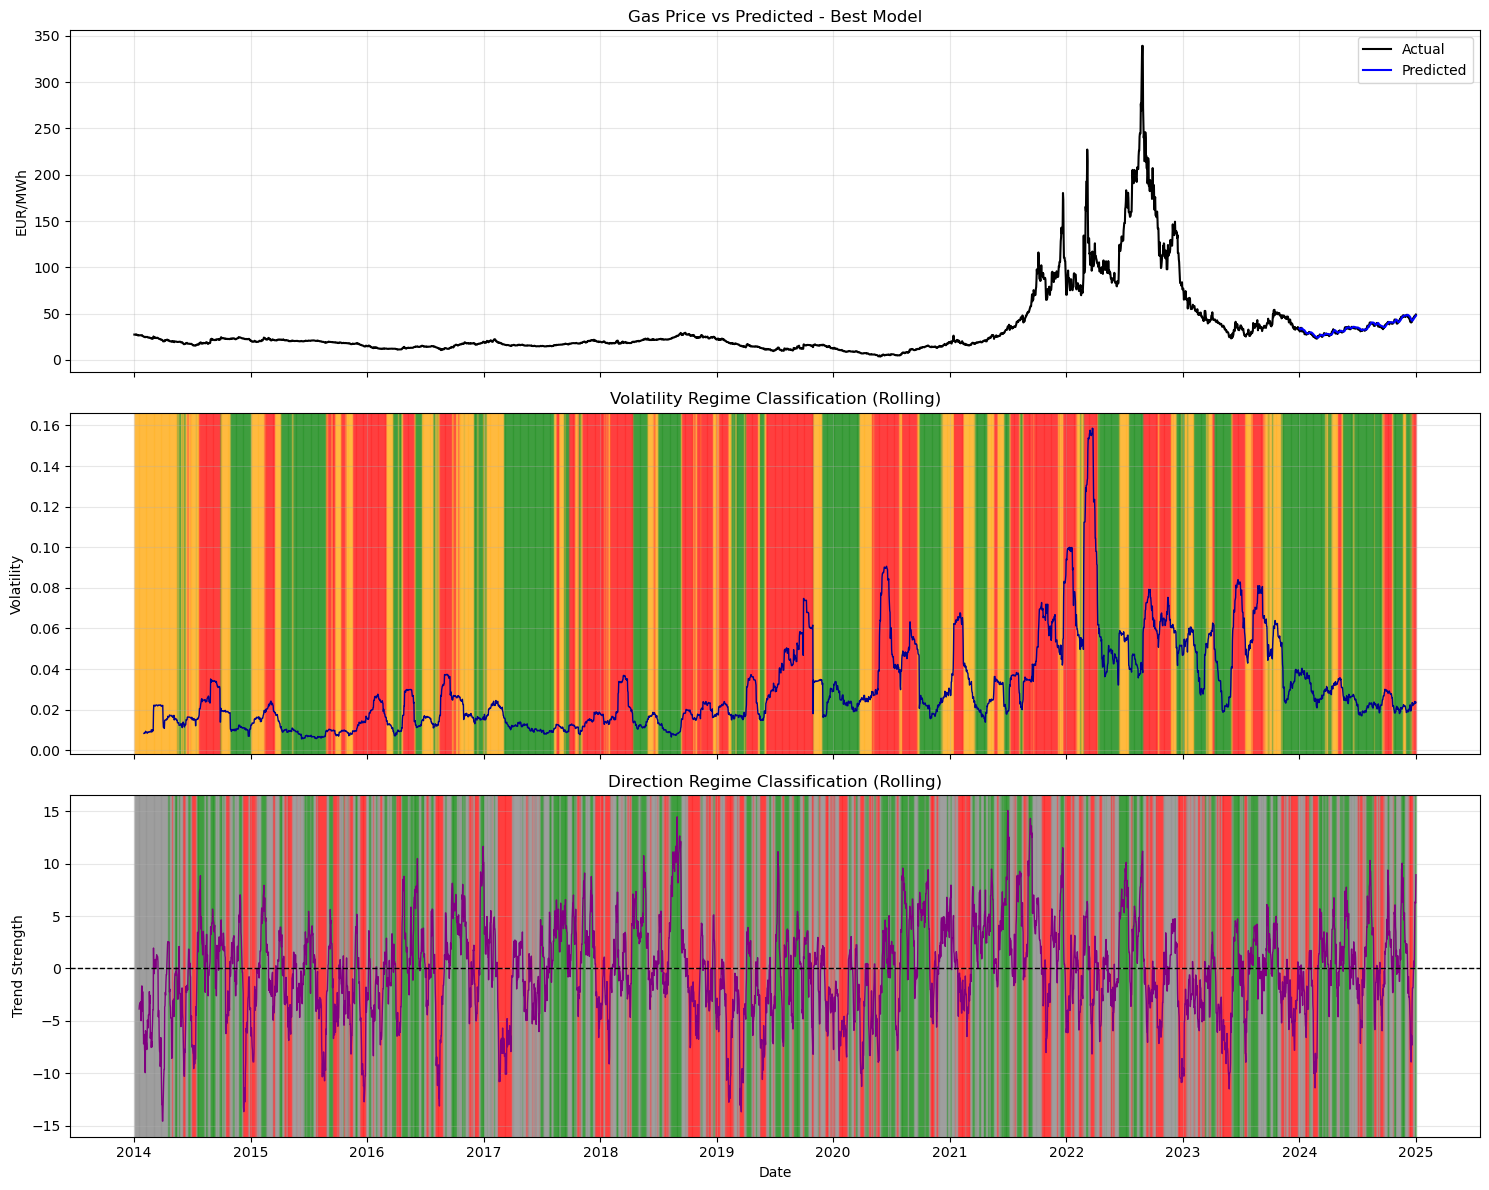

In [85]:
print("\n=== ROLLING REGIME CLASSIFICATION - BEST MODEL ===")

# Best model results 
best_model = test_compare.copy()  
best_model['date'] = best_model.index

# Unify series
full_df = pd.concat([
    data[['gas_price']],           
    best_model[['gp_pred']]        
], axis=1)

full_df = full_df.rename(columns={'gas_price': 'actual', 'gp_pred': 'pred'})
full_df['date'] = full_df.index

# 3. Log-returns
full_df['log_return'] = np.log(full_df['actual']).diff()

# 4. Volatility proxy
full_df['vol_30'] = full_df['log_return'].rolling(window=30).std()

# 5. Trend Strength
momentum = full_df['log_return'].rolling(window=15).sum()
vol = full_df['log_return'].rolling(window=15).std()
full_df['trend_strength'] = momentum / (vol + 1e-8)

# 6. Initialize regime columns
full_df['vol_regime'] = 'Medium'
full_df['dir_regime'] = 'Neutral'

# Rolling classification params
rolling_window_vol = 180
rolling_window_dir = 180
min_data_points = 90

for idx in range(len(full_df)):
    # Volatility regime
    start_vol = max(0, idx - rolling_window_vol)
    window_vol = full_df['vol_30'].iloc[start_vol:idx].dropna()

    if len(window_vol) >= min_data_points:
        q33, q66 = window_vol.quantile([0.33, 0.66])
        val = full_df['vol_30'].iloc[idx]
        if pd.notna(val):
            if val < q33:
                full_df.at[full_df.index[idx], 'vol_regime'] = 'Low'
            elif val > q66:
                full_df.at[full_df.index[idx], 'vol_regime'] = 'High'
            else:
                full_df.at[full_df.index[idx], 'vol_regime'] = 'Medium'

    # Direction regime
    start_dir = max(0, idx - rolling_window_dir)
    window_trend = full_df['trend_strength'].iloc[start_dir:idx].dropna()

    if len(window_trend) >= min_data_points:
        q25, q75 = window_trend.quantile([0.25, 0.75])
        val = full_df['trend_strength'].iloc[idx]
        if pd.notna(val):
            if val > q75:
                full_df.at[full_df.index[idx], 'dir_regime'] = 'Bull'
            elif val < q25:
                full_df.at[full_df.index[idx], 'dir_regime'] = 'Bear'
            else:
                full_df.at[full_df.index[idx], 'dir_regime'] = 'Neutral'

# 7. Final DataFrame
final_regime_df = full_df[['date', 'actual', 'pred', 'vol_regime', 'dir_regime']].copy()
final_regime_df.columns = ['date', 'gas_price', 'pred_price', 'vol_regime', 'dir_regime']

print("\nFinal regime-classified dataset:")
print(final_regime_df.tail())

# 8. Plot
import matplotlib.dates as mdates
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Plot 1 - Actual & Predicted
ax1.plot(final_regime_df['date'], final_regime_df['gas_price'], label='Actual', color='black')
ax1.plot(final_regime_df['date'], final_regime_df['pred_price'], label='Predicted', color='blue')
ax1.set_title('Gas Price vs Predicted - Best Model')
ax1.set_ylabel('EUR/MWh')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2 - Volatility Regime
vol_colors = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}
for i in range(len(final_regime_df) - 1):
    col = vol_colors.get(final_regime_df['vol_regime'].iloc[i], 'gray')
    ax2.axvspan(final_regime_df['date'].iloc[i], final_regime_df['date'].iloc[i+1], color=col, alpha=0.2)
ax2.plot(final_regime_df['date'], full_df['vol_30'], label='Volatility (30d)', color='darkblue', linewidth=1)
ax2.set_title('Volatility Regime Classification (Rolling)')
ax2.set_ylabel('Volatility')
ax2.grid(True, alpha=0.3)

# Plot 3 - Direction Regime
dir_colors = {'Bear': 'red', 'Neutral': 'gray', 'Bull': 'green'}
for i in range(len(final_regime_df) - 1):
    col = dir_colors.get(final_regime_df['dir_regime'].iloc[i], 'gray')
    ax3.axvspan(final_regime_df['date'].iloc[i], final_regime_df['date'].iloc[i+1], color=col, alpha=0.2)
ax3.plot(final_regime_df['date'], full_df['trend_strength'], label='Trend Strength', color='purple', linewidth=1)
ax3.axhline(0, color='black', linestyle='--', linewidth=1)
ax3.set_title('Direction Regime Classification (Rolling)')
ax3.set_ylabel('Trend Strength')
ax3.set_xlabel('Date')
ax3.grid(True, alpha=0.3)

# Format x-axis
ax3.xaxis.set_major_locator(mdates.YearLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

## Rolling Regime Classification: Final Signal Construction

### Indicators Constructed:
- **Log Returns**: ln(P_t) - ln(P_{t-1})
- **Volatility**: 30-day rolling standard deviation
- **Trend Strength**: 15-day momentum / 15-day volatility ratio

### Classification Parameters:
- **Rolling Window**: 180 days (adaptive thresholds)
- **Volatility Regimes**: Low (<33rd), Medium (33rd-66th), High (>66th percentile)
- **Direction Regimes**: Bear (<25th), Neutral (25th-75th), Bull (>75th percentile)


The final stage of this forecasting pipeline applies a **rolling regime classification** procedure to the historical and predicted gas prices. This transforms continuous prices into qualitative regime signals that describe volatility and direction market regimes.

I opted for a rolling classification for different reasons related to my final goal which is optimizing a hedging strategy. 
First, rolling quantiles allow the regime thresholds to adapt over time, accommodating changes in market conditions (e.g., crisis periods, seasonality). Second, rather than relying on static thresholds, rolling classification respects the dynamic distribution of the underlying series. Lastly, Local quantiles reduce the influence of long-term anomalies or regime shifts.


These classified regimes represent state inputs for the reinforcement learning (RL) agent in Part 2 of the project. Specifically:

- The **volatility regime** informs the RL agent about the risk environment.
- The **directional regime** provides a simplified signal of market momentum, potentially guiding the agent’s bias in exposure management.
